In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

Using GPU 1!


In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'exclude'       : ['normalized'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_normalized_e_e_0_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_0_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4486024 (17.11 MB)


Trainable params: 4486024 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/40 [..............................] - ETA: 5:57 - loss: 2.1375 - STD: 0.0510 - MAE: 0.2187

 2/40 [>.............................] - ETA: 2:41 - loss: 2.1129 - STD: 0.0426 - MAE: 0.2177

 3/40 [=>............................] - ETA: 1:25 - loss: 2.0921 - STD: 0.0424 - MAE: 0.2172

 4/40 [==>...........................] - ETA: 1:00 - loss: 2.0871 - STD: 0.0431 - MAE: 0.2170

 5/40 [==>...........................] - ETA: 47s - loss: 2.0848 - STD: 0.0439 - MAE: 0.2168 

 6/40 [===>..........................] - ETA: 39s - loss: 2.0823 - STD: 0.0443 - MAE: 0.2167

 7/40 [====>.........................] - ETA: 33s - loss: 2.0793 - STD: 0.0443 - MAE: 0.2166

 8/40 [=====>........................] - ETA: 29s - loss: 2.0767 - STD: 0.0436 - MAE: 0.2166

 9/40 [=====>........................] - ETA: 26s - loss: 2.0738 - STD: 0.0423 - MAE: 0.2166

10/40 [======>.......................] - ETA: 24s - loss: 2.0716 - STD: 0.0409 - MAE: 0.2166

11/40 [=======>......................] - ETA: 22s - loss: 2.0698 - STD: 0.0397 - MAE: 0.2167

12/40 [========>.....................] - ETA: 20s - loss: 2.0686 - STD: 0.0388 - MAE: 0.2167

13/40 [========>.....................] - ETA: 19s - loss: 2.0678 - STD: 0.0382 - MAE: 0.2167

14/40 [=========>....................] - ETA: 17s - loss: 2.0671 - STD: 0.0377 - MAE: 0.2168

15/40 [==========>...................] - ETA: 16s - loss: 2.0663 - STD: 0.0372 - MAE: 0.2168

16/40 [===========>..................] - ETA: 15s - loss: 2.0655 - STD: 0.0368 - MAE: 0.2168

17/40 [===========>..................] - ETA: 14s - loss: 2.0647 - STD: 0.0364 - MAE: 0.2168

18/40 [============>.................] - ETA: 13s - loss: 2.0639 - STD: 0.0361 - MAE: 0.2168

19/40 [=============>................] - ETA: 12s - loss: 2.0632 - STD: 0.0359 - MAE: 0.2168

20/40 [==============>...............] - ETA: 11s - loss: 2.0625 - STD: 0.0358 - MAE: 0.2168

21/40 [==============>...............] - ETA: 10s - loss: 2.0620 - STD: 0.0358 - MAE: 0.2167

22/40 [===============>..............] - ETA: 10s - loss: 2.0616 - STD: 0.0358 - MAE: 0.2167

23/40 [================>.............] - ETA: 9s - loss: 2.0612 - STD: 0.0359 - MAE: 0.2167 

24/40 [=================>............] - ETA: 8s - loss: 2.0608 - STD: 0.0359 - MAE: 0.2167

25/40 [=================>............] - ETA: 8s - loss: 2.0604 - STD: 0.0359 - MAE: 0.2167

26/40 [==================>...........] - ETA: 7s - loss: 2.0599 - STD: 0.0358 - MAE: 0.2167

27/40 [===================>..........] - ETA: 6s - loss: 2.0594 - STD: 0.0357 - MAE: 0.2167

28/40 [====================>.........] - ETA: 6s - loss: 2.0590 - STD: 0.0356 - MAE: 0.2167

29/40 [====================>.........] - ETA: 5s - loss: 2.0584 - STD: 0.0354 - MAE: 0.2167

30/40 [=====================>........] - ETA: 5s - loss: 2.0579 - STD: 0.0353 - MAE: 0.2167

31/40 [======================>.......] - ETA: 4s - loss: 2.0574 - STD: 0.0351 - MAE: 0.2167

32/40 [=======================>......] - ETA: 4s - loss: 2.0568 - STD: 0.0350 - MAE: 0.2167

33/40 [=======================>......] - ETA: 3s - loss: 2.0561 - STD: 0.0348 - MAE: 0.2166

34/40 [========================>.....] - ETA: 3s - loss: 2.0553 - STD: 0.0347 - MAE: 0.2166

35/40 [=========================>....] - ETA: 2s - loss: 2.0544 - STD: 0.0346 - MAE: 0.2166

36/40 [==========================>...] - ETA: 1s - loss: 2.0533 - STD: 0.0346 - MAE: 0.2166

37/40 [==========================>...] - ETA: 1s - loss: 2.0520 - STD: 0.0345 - MAE: 0.2165

38/40 [===========================>..] - ETA: 0s - loss: 2.0505 - STD: 0.0346 - MAE: 0.2165

39/40 [============================>.] - ETA: 0s - loss: 2.0487 - STD: 0.0347 - MAE: 0.2164

40/40 [==============================] - ETA: 0s - loss: 2.0467 - STD: 0.0348 - MAE: 0.2163

40/40 [==============================] - 32s 575ms/step - loss: 2.0467 - STD: 0.0348 - MAE: 0.2163 - val_loss: 1.9432 - val_STD: 0.0436 - val_MAE: 0.2124


Epoch 2/10000


 1/40 [..............................] - ETA: 21s - loss: 1.9539 - STD: 0.0450 - MAE: 0.2127

 2/40 [>.............................] - ETA: 14s - loss: 1.9467 - STD: 0.0472 - MAE: 0.2123

 3/40 [=>............................] - ETA: 14s - loss: 1.9393 - STD: 0.0488 - MAE: 0.2119

 4/40 [==>...........................] - ETA: 13s - loss: 1.9308 - STD: 0.0509 - MAE: 0.2115

 5/40 [==>...........................] - ETA: 13s - loss: 1.9226 - STD: 0.0526 - MAE: 0.2111

 6/40 [===>..........................] - ETA: 13s - loss: 1.9143 - STD: 0.0544 - MAE: 0.2106

 7/40 [====>.........................] - ETA: 12s - loss: 1.9060 - STD: 0.0561 - MAE: 0.2102

 8/40 [=====>........................] - ETA: 12s - loss: 1.8979 - STD: 0.0576 - MAE: 0.2098

 9/40 [=====>........................] - ETA: 11s - loss: 1.8955 - STD: 0.0592 - MAE: 0.2095

10/40 [======>.......................] - ETA: 10s - loss: 1.8887 - STD: 0.0607 - MAE: 0.2091

11/40 [=======>......................] - ETA: 10s - loss: 1.8801 - STD: 0.0621 - MAE: 0.2087

12/40 [========>.....................] - ETA: 10s - loss: 1.8744 - STD: 0.0635 - MAE: 0.2084

13/40 [========>.....................] - ETA: 9s - loss: 1.8670 - STD: 0.0647 - MAE: 0.2080 

14/40 [=========>....................] - ETA: 9s - loss: 1.8608 - STD: 0.0658 - MAE: 0.2077

15/40 [==========>...................] - ETA: 9s - loss: 1.8551 - STD: 0.0668 - MAE: 0.2074

16/40 [===========>..................] - ETA: 8s - loss: 1.8480 - STD: 0.0677 - MAE: 0.2070

17/40 [===========>..................] - ETA: 8s - loss: 1.8432 - STD: 0.0687 - MAE: 0.2067

18/40 [============>.................] - ETA: 8s - loss: 1.8367 - STD: 0.0695 - MAE: 0.2064

19/40 [=============>................] - ETA: 7s - loss: 1.8310 - STD: 0.0703 - MAE: 0.2061

20/40 [==============>...............] - ETA: 7s - loss: 1.8252 - STD: 0.0712 - MAE: 0.2058

21/40 [==============>...............] - ETA: 7s - loss: 1.8188 - STD: 0.0720 - MAE: 0.2055

22/40 [===============>..............] - ETA: 6s - loss: 1.8132 - STD: 0.0728 - MAE: 0.2051

23/40 [================>.............] - ETA: 6s - loss: 1.8068 - STD: 0.0738 - MAE: 0.2047

24/40 [=================>............] - ETA: 6s - loss: 1.8006 - STD: 0.0747 - MAE: 0.2044

25/40 [=================>............] - ETA: 5s - loss: 1.7948 - STD: 0.0756 - MAE: 0.2040

26/40 [==================>...........] - ETA: 5s - loss: 1.7883 - STD: 0.0767 - MAE: 0.2036

27/40 [===================>..........] - ETA: 4s - loss: 1.7825 - STD: 0.0778 - MAE: 0.2032

28/40 [====================>.........] - ETA: 4s - loss: 1.7768 - STD: 0.0788 - MAE: 0.2028

29/40 [====================>.........] - ETA: 4s - loss: 1.7705 - STD: 0.0799 - MAE: 0.2024

30/40 [=====================>........] - ETA: 3s - loss: 1.7646 - STD: 0.0811 - MAE: 0.2019

31/40 [======================>.......] - ETA: 3s - loss: 1.7590 - STD: 0.0822 - MAE: 0.2015

32/40 [=======================>......] - ETA: 3s - loss: 1.7529 - STD: 0.0832 - MAE: 0.2011

33/40 [=======================>......] - ETA: 2s - loss: 1.7470 - STD: 0.0843 - MAE: 0.2007

34/40 [========================>.....] - ETA: 2s - loss: 1.7416 - STD: 0.0854 - MAE: 0.2003

35/40 [=========================>....] - ETA: 1s - loss: 1.7364 - STD: 0.0864 - MAE: 0.1999

36/40 [==========================>...] - ETA: 1s - loss: 1.7308 - STD: 0.0875 - MAE: 0.1995

37/40 [==========================>...] - ETA: 1s - loss: 1.7255 - STD: 0.0884 - MAE: 0.1991

38/40 [===========================>..] - ETA: 0s - loss: 1.7207 - STD: 0.0895 - MAE: 0.1987

39/40 [============================>.] - ETA: 0s - loss: 1.7155 - STD: 0.0904 - MAE: 0.1983

40/40 [==============================] - ETA: 0s - loss: 1.7106 - STD: 0.0913 - MAE: 0.1980

40/40 [==============================] - 17s 411ms/step - loss: 1.7106 - STD: 0.0913 - MAE: 0.1980 - val_loss: 1.4511 - val_STD: 0.1237 - val_MAE: 0.1817


Epoch 3/10000


 1/40 [..............................] - ETA: 21s - loss: 1.5197 - STD: 0.1292 - MAE: 0.1833

 2/40 [>.............................] - ETA: 14s - loss: 1.5174 - STD: 0.1282 - MAE: 0.1834

 3/40 [=>............................] - ETA: 14s - loss: 1.5173 - STD: 0.1291 - MAE: 0.1832

 4/40 [==>...........................] - ETA: 13s - loss: 1.5132 - STD: 0.1296 - MAE: 0.1830

 5/40 [==>...........................] - ETA: 13s - loss: 1.5120 - STD: 0.1296 - MAE: 0.1830

 6/40 [===>..........................] - ETA: 13s - loss: 1.5104 - STD: 0.1302 - MAE: 0.1828

 7/40 [====>.........................] - ETA: 12s - loss: 1.5077 - STD: 0.1304 - MAE: 0.1826

 8/40 [=====>........................] - ETA: 12s - loss: 1.5055 - STD: 0.1305 - MAE: 0.1825

 9/40 [=====>........................] - ETA: 11s - loss: 1.5047 - STD: 0.1309 - MAE: 0.1824

10/40 [======>.......................] - ETA: 11s - loss: 1.5028 - STD: 0.1310 - MAE: 0.1823

11/40 [=======>......................] - ETA: 11s - loss: 1.4999 - STD: 0.1313 - MAE: 0.1821

12/40 [========>.....................] - ETA: 10s - loss: 1.4978 - STD: 0.1317 - MAE: 0.1819

13/40 [========>.....................] - ETA: 10s - loss: 1.4963 - STD: 0.1318 - MAE: 0.1818

14/40 [=========>....................] - ETA: 10s - loss: 1.4946 - STD: 0.1322 - MAE: 0.1816

15/40 [==========>...................] - ETA: 9s - loss: 1.4925 - STD: 0.1325 - MAE: 0.1815 

16/40 [===========>..................] - ETA: 9s - loss: 1.4906 - STD: 0.1327 - MAE: 0.1813

17/40 [===========>..................] - ETA: 8s - loss: 1.4886 - STD: 0.1330 - MAE: 0.1811

18/40 [============>.................] - ETA: 8s - loss: 1.4868 - STD: 0.1332 - MAE: 0.1810

19/40 [=============>................] - ETA: 8s - loss: 1.4854 - STD: 0.1335 - MAE: 0.1809

20/40 [==============>...............] - ETA: 7s - loss: 1.4838 - STD: 0.1337 - MAE: 0.1807

21/40 [==============>...............] - ETA: 7s - loss: 1.4830 - STD: 0.1340 - MAE: 0.1806

22/40 [===============>..............] - ETA: 6s - loss: 1.4814 - STD: 0.1342 - MAE: 0.1805

23/40 [================>.............] - ETA: 6s - loss: 1.4799 - STD: 0.1344 - MAE: 0.1803

24/40 [=================>............] - ETA: 6s - loss: 1.4785 - STD: 0.1347 - MAE: 0.1802

25/40 [=================>............] - ETA: 5s - loss: 1.4767 - STD: 0.1349 - MAE: 0.1801

26/40 [==================>...........] - ETA: 5s - loss: 1.4751 - STD: 0.1350 - MAE: 0.1800

27/40 [===================>..........] - ETA: 4s - loss: 1.4736 - STD: 0.1353 - MAE: 0.1798

28/40 [====================>.........] - ETA: 4s - loss: 1.4722 - STD: 0.1355 - MAE: 0.1797

29/40 [====================>.........] - ETA: 4s - loss: 1.4706 - STD: 0.1357 - MAE: 0.1796

30/40 [=====================>........] - ETA: 3s - loss: 1.4692 - STD: 0.1359 - MAE: 0.1795

31/40 [======================>.......] - ETA: 3s - loss: 1.4683 - STD: 0.1361 - MAE: 0.1794

32/40 [=======================>......] - ETA: 3s - loss: 1.4683 - STD: 0.1362 - MAE: 0.1794

33/40 [=======================>......] - ETA: 2s - loss: 1.4682 - STD: 0.1365 - MAE: 0.1793

34/40 [========================>.....] - ETA: 2s - loss: 1.4671 - STD: 0.1366 - MAE: 0.1792

35/40 [=========================>....] - ETA: 1s - loss: 1.4659 - STD: 0.1367 - MAE: 0.1791

36/40 [==========================>...] - ETA: 1s - loss: 1.4654 - STD: 0.1369 - MAE: 0.1790

37/40 [==========================>...] - ETA: 1s - loss: 1.4643 - STD: 0.1371 - MAE: 0.1789

38/40 [===========================>..] - ETA: 0s - loss: 1.4630 - STD: 0.1373 - MAE: 0.1788

39/40 [============================>.] - ETA: 0s - loss: 1.4623 - STD: 0.1376 - MAE: 0.1787

40/40 [==============================] - ETA: 0s - loss: 1.4612 - STD: 0.1377 - MAE: 0.1786

40/40 [==============================] - 17s 411ms/step - loss: 1.4612 - STD: 0.1377 - MAE: 0.1786 - val_loss: 1.3766 - val_STD: 0.1407 - val_MAE: 0.1737


Epoch 4/10000


 1/40 [..............................] - ETA: 21s - loss: 1.4133 - STD: 0.1442 - MAE: 0.1748

 2/40 [>.............................] - ETA: 14s - loss: 1.4191 - STD: 0.1449 - MAE: 0.1748

 3/40 [=>............................] - ETA: 14s - loss: 1.4144 - STD: 0.1444 - MAE: 0.1747

 4/40 [==>...........................] - ETA: 13s - loss: 1.4146 - STD: 0.1444 - MAE: 0.1747

 5/40 [==>...........................] - ETA: 13s - loss: 1.4157 - STD: 0.1447 - MAE: 0.1747

 6/40 [===>..........................] - ETA: 13s - loss: 1.4128 - STD: 0.1449 - MAE: 0.1745

 7/40 [====>.........................] - ETA: 11s - loss: 1.4124 - STD: 0.1451 - MAE: 0.1744

 8/40 [=====>........................] - ETA: 11s - loss: 1.4123 - STD: 0.1454 - MAE: 0.1743

 9/40 [=====>........................] - ETA: 11s - loss: 1.4103 - STD: 0.1455 - MAE: 0.1742

10/40 [======>.......................] - ETA: 10s - loss: 1.4092 - STD: 0.1454 - MAE: 0.1742

11/40 [=======>......................] - ETA: 10s - loss: 1.4087 - STD: 0.1456 - MAE: 0.1741

12/40 [========>.....................] - ETA: 10s - loss: 1.4068 - STD: 0.1457 - MAE: 0.1740

13/40 [========>.....................] - ETA: 9s - loss: 1.4061 - STD: 0.1457 - MAE: 0.1739 

14/40 [=========>....................] - ETA: 9s - loss: 1.4057 - STD: 0.1460 - MAE: 0.1738

15/40 [==========>...................] - ETA: 9s - loss: 1.4044 - STD: 0.1461 - MAE: 0.1738

16/40 [===========>..................] - ETA: 8s - loss: 1.4036 - STD: 0.1463 - MAE: 0.1737

17/40 [===========>..................] - ETA: 8s - loss: 1.4030 - STD: 0.1464 - MAE: 0.1736

18/40 [============>.................] - ETA: 8s - loss: 1.4019 - STD: 0.1466 - MAE: 0.1735

19/40 [=============>................] - ETA: 7s - loss: 1.4008 - STD: 0.1467 - MAE: 0.1734

20/40 [==============>...............] - ETA: 7s - loss: 1.4000 - STD: 0.1469 - MAE: 0.1733

21/40 [==============>...............] - ETA: 7s - loss: 1.3990 - STD: 0.1470 - MAE: 0.1733

22/40 [===============>..............] - ETA: 6s - loss: 1.3977 - STD: 0.1471 - MAE: 0.1732

23/40 [================>.............] - ETA: 6s - loss: 1.3970 - STD: 0.1473 - MAE: 0.1731

24/40 [=================>............] - ETA: 6s - loss: 1.3966 - STD: 0.1473 - MAE: 0.1730

25/40 [=================>............] - ETA: 5s - loss: 1.3962 - STD: 0.1476 - MAE: 0.1729

26/40 [==================>...........] - ETA: 5s - loss: 1.3961 - STD: 0.1476 - MAE: 0.1729

27/40 [===================>..........] - ETA: 4s - loss: 1.3958 - STD: 0.1478 - MAE: 0.1728

28/40 [====================>.........] - ETA: 4s - loss: 1.3948 - STD: 0.1479 - MAE: 0.1728

29/40 [====================>.........] - ETA: 4s - loss: 1.3938 - STD: 0.1480 - MAE: 0.1727

30/40 [=====================>........] - ETA: 3s - loss: 1.3934 - STD: 0.1482 - MAE: 0.1726

31/40 [======================>.......] - ETA: 3s - loss: 1.3930 - STD: 0.1483 - MAE: 0.1726

32/40 [=======================>......] - ETA: 3s - loss: 1.3920 - STD: 0.1484 - MAE: 0.1725

33/40 [=======================>......] - ETA: 2s - loss: 1.3911 - STD: 0.1485 - MAE: 0.1724

34/40 [========================>.....] - ETA: 2s - loss: 1.3905 - STD: 0.1486 - MAE: 0.1723

35/40 [=========================>....] - ETA: 1s - loss: 1.3899 - STD: 0.1488 - MAE: 0.1723

36/40 [==========================>...] - ETA: 1s - loss: 1.3890 - STD: 0.1489 - MAE: 0.1722

37/40 [==========================>...] - ETA: 1s - loss: 1.3881 - STD: 0.1490 - MAE: 0.1721

38/40 [===========================>..] - ETA: 0s - loss: 1.3875 - STD: 0.1492 - MAE: 0.1720

39/40 [============================>.] - ETA: 0s - loss: 1.3869 - STD: 0.1493 - MAE: 0.1719

40/40 [==============================] - ETA: 0s - loss: 1.3861 - STD: 0.1495 - MAE: 0.1719

40/40 [==============================] - 17s 411ms/step - loss: 1.3861 - STD: 0.1495 - MAE: 0.1719 - val_loss: 1.3396 - val_STD: 0.1558 - val_MAE: 0.1681


Epoch 5/10000


 1/40 [..............................] - ETA: 21s - loss: 1.3607 - STD: 0.1560 - MAE: 0.1686

 2/40 [>.............................] - ETA: 14s - loss: 1.3607 - STD: 0.1543 - MAE: 0.1691

 3/40 [=>............................] - ETA: 14s - loss: 1.3581 - STD: 0.1550 - MAE: 0.1688

 4/40 [==>...........................] - ETA: 13s - loss: 1.3561 - STD: 0.1549 - MAE: 0.1687

 5/40 [==>...........................] - ETA: 13s - loss: 1.3562 - STD: 0.1550 - MAE: 0.1687

 6/40 [===>..........................] - ETA: 13s - loss: 1.3578 - STD: 0.1554 - MAE: 0.1686

 7/40 [====>.........................] - ETA: 12s - loss: 1.3589 - STD: 0.1555 - MAE: 0.1686

 8/40 [=====>........................] - ETA: 12s - loss: 1.3598 - STD: 0.1555 - MAE: 0.1687

 9/40 [=====>........................] - ETA: 12s - loss: 1.3603 - STD: 0.1558 - MAE: 0.1686

10/40 [======>.......................] - ETA: 10s - loss: 1.3596 - STD: 0.1556 - MAE: 0.1686

11/40 [=======>......................] - ETA: 10s - loss: 1.3570 - STD: 0.1557 - MAE: 0.1684

12/40 [========>.....................] - ETA: 10s - loss: 1.3553 - STD: 0.1560 - MAE: 0.1683

13/40 [========>.....................] - ETA: 9s - loss: 1.3551 - STD: 0.1560 - MAE: 0.1683 

14/40 [=========>....................] - ETA: 9s - loss: 1.3541 - STD: 0.1562 - MAE: 0.1682

15/40 [==========>...................] - ETA: 9s - loss: 1.3539 - STD: 0.1563 - MAE: 0.1681

16/40 [===========>..................] - ETA: 8s - loss: 1.3535 - STD: 0.1564 - MAE: 0.1681

17/40 [===========>..................] - ETA: 8s - loss: 1.3524 - STD: 0.1565 - MAE: 0.1680

18/40 [============>.................] - ETA: 8s - loss: 1.3509 - STD: 0.1565 - MAE: 0.1679

19/40 [=============>................] - ETA: 7s - loss: 1.3501 - STD: 0.1565 - MAE: 0.1679

20/40 [==============>...............] - ETA: 7s - loss: 1.3494 - STD: 0.1567 - MAE: 0.1678

21/40 [==============>...............] - ETA: 7s - loss: 1.3489 - STD: 0.1568 - MAE: 0.1677

22/40 [===============>..............] - ETA: 6s - loss: 1.3485 - STD: 0.1568 - MAE: 0.1677

23/40 [================>.............] - ETA: 6s - loss: 1.3479 - STD: 0.1570 - MAE: 0.1676

24/40 [=================>............] - ETA: 6s - loss: 1.3472 - STD: 0.1570 - MAE: 0.1676

25/40 [=================>............] - ETA: 5s - loss: 1.3460 - STD: 0.1571 - MAE: 0.1675

26/40 [==================>...........] - ETA: 5s - loss: 1.3449 - STD: 0.1572 - MAE: 0.1674

27/40 [===================>..........] - ETA: 4s - loss: 1.3438 - STD: 0.1574 - MAE: 0.1673

28/40 [====================>.........] - ETA: 4s - loss: 1.3427 - STD: 0.1575 - MAE: 0.1672

29/40 [====================>.........] - ETA: 4s - loss: 1.3416 - STD: 0.1576 - MAE: 0.1671

30/40 [=====================>........] - ETA: 3s - loss: 1.3408 - STD: 0.1577 - MAE: 0.1671

31/40 [======================>.......] - ETA: 3s - loss: 1.3404 - STD: 0.1578 - MAE: 0.1670

32/40 [=======================>......] - ETA: 3s - loss: 1.3402 - STD: 0.1579 - MAE: 0.1670

33/40 [=======================>......] - ETA: 2s - loss: 1.3403 - STD: 0.1580 - MAE: 0.1669

34/40 [========================>.....] - ETA: 2s - loss: 1.3406 - STD: 0.1581 - MAE: 0.1669

35/40 [=========================>....] - ETA: 1s - loss: 1.3403 - STD: 0.1582 - MAE: 0.1669

36/40 [==========================>...] - ETA: 1s - loss: 1.3395 - STD: 0.1583 - MAE: 0.1668

37/40 [==========================>...] - ETA: 1s - loss: 1.3386 - STD: 0.1584 - MAE: 0.1667

38/40 [===========================>..] - ETA: 0s - loss: 1.3382 - STD: 0.1585 - MAE: 0.1667

39/40 [============================>.] - ETA: 0s - loss: 1.3378 - STD: 0.1586 - MAE: 0.1666

40/40 [==============================] - ETA: 0s - loss: 1.3376 - STD: 0.1587 - MAE: 0.1665

40/40 [==============================] - 17s 410ms/step - loss: 1.3376 - STD: 0.1587 - MAE: 0.1665 - val_loss: 1.3440 - val_STD: 0.1614 - val_MAE: 0.1658


Epoch 6/10000


 1/40 [..............................] - ETA: 21s - loss: 1.3222 - STD: 0.1606 - MAE: 0.1651

 2/40 [>.............................] - ETA: 14s - loss: 1.3129 - STD: 0.1611 - MAE: 0.1645

 3/40 [=>............................] - ETA: 14s - loss: 1.3076 - STD: 0.1612 - MAE: 0.1642

 4/40 [==>...........................] - ETA: 13s - loss: 1.3103 - STD: 0.1615 - MAE: 0.1642

 5/40 [==>...........................] - ETA: 13s - loss: 1.3124 - STD: 0.1620 - MAE: 0.1641

 6/40 [===>..........................] - ETA: 13s - loss: 1.3112 - STD: 0.1622 - MAE: 0.1640

 7/40 [====>.........................] - ETA: 12s - loss: 1.3085 - STD: 0.1622 - MAE: 0.1639

 8/40 [=====>........................] - ETA: 12s - loss: 1.3070 - STD: 0.1624 - MAE: 0.1638

 9/40 [=====>........................] - ETA: 11s - loss: 1.3073 - STD: 0.1626 - MAE: 0.1637

10/40 [======>.......................] - ETA: 11s - loss: 1.3071 - STD: 0.1627 - MAE: 0.1637

11/40 [=======>......................] - ETA: 11s - loss: 1.3062 - STD: 0.1629 - MAE: 0.1636

12/40 [========>.....................] - ETA: 10s - loss: 1.3050 - STD: 0.1629 - MAE: 0.1635

13/40 [========>.....................] - ETA: 10s - loss: 1.3037 - STD: 0.1630 - MAE: 0.1634

14/40 [=========>....................] - ETA: 10s - loss: 1.3027 - STD: 0.1631 - MAE: 0.1634

15/40 [==========>...................] - ETA: 9s - loss: 1.3023 - STD: 0.1632 - MAE: 0.1633 

16/40 [===========>..................] - ETA: 8s - loss: 1.3017 - STD: 0.1634 - MAE: 0.1632

17/40 [===========>..................] - ETA: 8s - loss: 1.3006 - STD: 0.1634 - MAE: 0.1631

18/40 [============>.................] - ETA: 8s - loss: 1.2995 - STD: 0.1635 - MAE: 0.1630

19/40 [=============>................] - ETA: 7s - loss: 1.2986 - STD: 0.1637 - MAE: 0.1629

20/40 [==============>...............] - ETA: 7s - loss: 1.2977 - STD: 0.1638 - MAE: 0.1628

21/40 [==============>...............] - ETA: 7s - loss: 1.2968 - STD: 0.1640 - MAE: 0.1627

22/40 [===============>..............] - ETA: 6s - loss: 1.2960 - STD: 0.1641 - MAE: 0.1627

23/40 [================>.............] - ETA: 6s - loss: 1.2957 - STD: 0.1642 - MAE: 0.1626

24/40 [=================>............] - ETA: 6s - loss: 1.2957 - STD: 0.1643 - MAE: 0.1626

25/40 [=================>............] - ETA: 5s - loss: 1.2955 - STD: 0.1644 - MAE: 0.1625

26/40 [==================>...........] - ETA: 5s - loss: 1.2954 - STD: 0.1644 - MAE: 0.1625

27/40 [===================>..........] - ETA: 4s - loss: 1.2955 - STD: 0.1646 - MAE: 0.1625

28/40 [====================>.........] - ETA: 4s - loss: 1.2949 - STD: 0.1646 - MAE: 0.1624

29/40 [====================>.........] - ETA: 4s - loss: 1.2941 - STD: 0.1647 - MAE: 0.1624

30/40 [=====================>........] - ETA: 3s - loss: 1.2932 - STD: 0.1649 - MAE: 0.1623

31/40 [======================>.......] - ETA: 3s - loss: 1.2924 - STD: 0.1650 - MAE: 0.1622

32/40 [=======================>......] - ETA: 3s - loss: 1.2917 - STD: 0.1651 - MAE: 0.1621

33/40 [=======================>......] - ETA: 2s - loss: 1.2911 - STD: 0.1652 - MAE: 0.1621

34/40 [========================>.....] - ETA: 2s - loss: 1.2911 - STD: 0.1652 - MAE: 0.1621

35/40 [=========================>....] - ETA: 1s - loss: 1.2914 - STD: 0.1654 - MAE: 0.1620

36/40 [==========================>...] - ETA: 1s - loss: 1.2919 - STD: 0.1655 - MAE: 0.1620

37/40 [==========================>...] - ETA: 1s - loss: 1.2928 - STD: 0.1655 - MAE: 0.1620

38/40 [===========================>..] - ETA: 0s - loss: 1.2932 - STD: 0.1656 - MAE: 0.1620

39/40 [============================>.] - ETA: 0s - loss: 1.2925 - STD: 0.1657 - MAE: 0.1619

40/40 [==============================] - ETA: 0s - loss: 1.2917 - STD: 0.1658 - MAE: 0.1619

40/40 [==============================] - 17s 412ms/step - loss: 1.2917 - STD: 0.1658 - MAE: 0.1619 - val_loss: 1.2836 - val_STD: 0.1728 - val_MAE: 0.1594


Epoch 7/10000


 1/40 [..............................] - ETA: 21s - loss: 1.2832 - STD: 0.1722 - MAE: 0.1595

 2/40 [>.............................] - ETA: 14s - loss: 1.2887 - STD: 0.1705 - MAE: 0.1601

 3/40 [=>............................] - ETA: 14s - loss: 1.2840 - STD: 0.1697 - MAE: 0.1601

 4/40 [==>...........................] - ETA: 13s - loss: 1.2795 - STD: 0.1698 - MAE: 0.1599

 5/40 [==>...........................] - ETA: 13s - loss: 1.2770 - STD: 0.1698 - MAE: 0.1598

 6/40 [===>..........................] - ETA: 13s - loss: 1.2766 - STD: 0.1697 - MAE: 0.1598

 7/40 [====>.........................] - ETA: 12s - loss: 1.2764 - STD: 0.1698 - MAE: 0.1597

 8/40 [=====>........................] - ETA: 12s - loss: 1.2737 - STD: 0.1696 - MAE: 0.1596

 9/40 [=====>........................] - ETA: 11s - loss: 1.2710 - STD: 0.1696 - MAE: 0.1595

10/40 [======>.......................] - ETA: 11s - loss: 1.2711 - STD: 0.1700 - MAE: 0.1594

11/40 [=======>......................] - ETA: 11s - loss: 1.2711 - STD: 0.1700 - MAE: 0.1594

12/40 [========>.....................] - ETA: 10s - loss: 1.2701 - STD: 0.1700 - MAE: 0.1593

13/40 [========>.....................] - ETA: 10s - loss: 1.2691 - STD: 0.1701 - MAE: 0.1592

14/40 [=========>....................] - ETA: 10s - loss: 1.2681 - STD: 0.1702 - MAE: 0.1592

15/40 [==========>...................] - ETA: 9s - loss: 1.2674 - STD: 0.1703 - MAE: 0.1591 

16/40 [===========>..................] - ETA: 9s - loss: 1.2672 - STD: 0.1704 - MAE: 0.1591

17/40 [===========>..................] - ETA: 8s - loss: 1.2668 - STD: 0.1703 - MAE: 0.1591

18/40 [============>.................] - ETA: 8s - loss: 1.2655 - STD: 0.1704 - MAE: 0.1590

19/40 [=============>................] - ETA: 8s - loss: 1.2646 - STD: 0.1705 - MAE: 0.1589

20/40 [==============>...............] - ETA: 7s - loss: 1.2638 - STD: 0.1705 - MAE: 0.1589

21/40 [==============>...............] - ETA: 7s - loss: 1.2630 - STD: 0.1706 - MAE: 0.1588

22/40 [===============>..............] - ETA: 6s - loss: 1.2623 - STD: 0.1706 - MAE: 0.1587

23/40 [================>.............] - ETA: 6s - loss: 1.2616 - STD: 0.1707 - MAE: 0.1587

24/40 [=================>............] - ETA: 6s - loss: 1.2605 - STD: 0.1708 - MAE: 0.1586

25/40 [=================>............] - ETA: 5s - loss: 1.2601 - STD: 0.1709 - MAE: 0.1585

26/40 [==================>...........] - ETA: 5s - loss: 1.2592 - STD: 0.1709 - MAE: 0.1585

27/40 [===================>..........] - ETA: 4s - loss: 1.2582 - STD: 0.1711 - MAE: 0.1584

28/40 [====================>.........] - ETA: 4s - loss: 1.2571 - STD: 0.1711 - MAE: 0.1583

29/40 [====================>.........] - ETA: 4s - loss: 1.2562 - STD: 0.1712 - MAE: 0.1582

30/40 [=====================>........] - ETA: 3s - loss: 1.2556 - STD: 0.1713 - MAE: 0.1582

31/40 [======================>.......] - ETA: 3s - loss: 1.2552 - STD: 0.1714 - MAE: 0.1581

32/40 [=======================>......] - ETA: 3s - loss: 1.2554 - STD: 0.1716 - MAE: 0.1581

33/40 [=======================>......] - ETA: 2s - loss: 1.2567 - STD: 0.1717 - MAE: 0.1581

34/40 [========================>.....] - ETA: 2s - loss: 1.2594 - STD: 0.1718 - MAE: 0.1581

35/40 [=========================>....] - ETA: 1s - loss: 1.2613 - STD: 0.1719 - MAE: 0.1582

36/40 [==========================>...] - ETA: 1s - loss: 1.2611 - STD: 0.1720 - MAE: 0.1581

37/40 [==========================>...] - ETA: 1s - loss: 1.2603 - STD: 0.1720 - MAE: 0.1581

38/40 [===========================>..] - ETA: 0s - loss: 1.2605 - STD: 0.1721 - MAE: 0.1581

39/40 [============================>.] - ETA: 0s - loss: 1.2609 - STD: 0.1722 - MAE: 0.1580

40/40 [==============================] - ETA: 0s - loss: 1.2605 - STD: 0.1722 - MAE: 0.1580

40/40 [==============================] - 17s 412ms/step - loss: 1.2605 - STD: 0.1722 - MAE: 0.1580 - val_loss: 1.2352 - val_STD: 0.1756 - val_MAE: 0.1547


Epoch 8/10000


 1/40 [..............................] - ETA: 21s - loss: 1.2237 - STD: 0.1749 - MAE: 0.1552

 2/40 [>.............................] - ETA: 14s - loss: 1.2466 - STD: 0.1760 - MAE: 0.1560

 3/40 [=>............................] - ETA: 14s - loss: 1.2511 - STD: 0.1751 - MAE: 0.1565

 4/40 [==>...........................] - ETA: 13s - loss: 1.2463 - STD: 0.1748 - MAE: 0.1564

 5/40 [==>...........................] - ETA: 13s - loss: 1.2449 - STD: 0.1749 - MAE: 0.1563

 6/40 [===>..........................] - ETA: 13s - loss: 1.2458 - STD: 0.1753 - MAE: 0.1562

 7/40 [====>.........................] - ETA: 12s - loss: 1.2439 - STD: 0.1752 - MAE: 0.1562

 8/40 [=====>........................] - ETA: 12s - loss: 1.2428 - STD: 0.1749 - MAE: 0.1562

 9/40 [=====>........................] - ETA: 11s - loss: 1.2429 - STD: 0.1751 - MAE: 0.1562

10/40 [======>.......................] - ETA: 10s - loss: 1.2417 - STD: 0.1753 - MAE: 0.1560

11/40 [=======>......................] - ETA: 10s - loss: 1.2410 - STD: 0.1753 - MAE: 0.1560

12/40 [========>.....................] - ETA: 10s - loss: 1.2399 - STD: 0.1753 - MAE: 0.1559

13/40 [========>.....................] - ETA: 9s - loss: 1.2384 - STD: 0.1755 - MAE: 0.1558 

14/40 [=========>....................] - ETA: 9s - loss: 1.2374 - STD: 0.1756 - MAE: 0.1557

15/40 [==========>...................] - ETA: 9s - loss: 1.2368 - STD: 0.1757 - MAE: 0.1556

16/40 [===========>..................] - ETA: 8s - loss: 1.2358 - STD: 0.1757 - MAE: 0.1556

17/40 [===========>..................] - ETA: 8s - loss: 1.2343 - STD: 0.1758 - MAE: 0.1555

18/40 [============>.................] - ETA: 8s - loss: 1.2336 - STD: 0.1759 - MAE: 0.1554

19/40 [=============>................] - ETA: 7s - loss: 1.2330 - STD: 0.1759 - MAE: 0.1554

20/40 [==============>...............] - ETA: 7s - loss: 1.2321 - STD: 0.1759 - MAE: 0.1553

21/40 [==============>...............] - ETA: 7s - loss: 1.2314 - STD: 0.1760 - MAE: 0.1552

22/40 [===============>..............] - ETA: 6s - loss: 1.2309 - STD: 0.1761 - MAE: 0.1552

23/40 [================>.............] - ETA: 6s - loss: 1.2301 - STD: 0.1761 - MAE: 0.1551

24/40 [=================>............] - ETA: 6s - loss: 1.2293 - STD: 0.1761 - MAE: 0.1551

25/40 [=================>............] - ETA: 5s - loss: 1.2288 - STD: 0.1762 - MAE: 0.1550

26/40 [==================>...........] - ETA: 5s - loss: 1.2282 - STD: 0.1763 - MAE: 0.1550

27/40 [===================>..........] - ETA: 4s - loss: 1.2275 - STD: 0.1764 - MAE: 0.1549

28/40 [====================>.........] - ETA: 4s - loss: 1.2265 - STD: 0.1765 - MAE: 0.1548

29/40 [====================>.........] - ETA: 4s - loss: 1.2258 - STD: 0.1766 - MAE: 0.1548

30/40 [=====================>........] - ETA: 3s - loss: 1.2248 - STD: 0.1767 - MAE: 0.1547

31/40 [======================>.......] - ETA: 3s - loss: 1.2243 - STD: 0.1767 - MAE: 0.1546

32/40 [=======================>......] - ETA: 3s - loss: 1.2235 - STD: 0.1768 - MAE: 0.1546

33/40 [=======================>......] - ETA: 2s - loss: 1.2228 - STD: 0.1769 - MAE: 0.1545

34/40 [========================>.....] - ETA: 2s - loss: 1.2222 - STD: 0.1770 - MAE: 0.1544

35/40 [=========================>....] - ETA: 1s - loss: 1.2215 - STD: 0.1771 - MAE: 0.1544

36/40 [==========================>...] - ETA: 1s - loss: 1.2209 - STD: 0.1772 - MAE: 0.1543

37/40 [==========================>...] - ETA: 1s - loss: 1.2203 - STD: 0.1773 - MAE: 0.1542

38/40 [===========================>..] - ETA: 0s - loss: 1.2198 - STD: 0.1774 - MAE: 0.1542

39/40 [============================>.] - ETA: 0s - loss: 1.2193 - STD: 0.1775 - MAE: 0.1541

40/40 [==============================] - ETA: 0s - loss: 1.2189 - STD: 0.1776 - MAE: 0.1541

40/40 [==============================] - 17s 412ms/step - loss: 1.2189 - STD: 0.1776 - MAE: 0.1541 - val_loss: 1.2175 - val_STD: 0.1826 - val_MAE: 0.1512


Epoch 9/10000


 1/40 [..............................] - ETA: 21s - loss: 1.2053 - STD: 0.1810 - MAE: 0.1519

 2/40 [>.............................] - ETA: 14s - loss: 1.2092 - STD: 0.1814 - MAE: 0.1521

 3/40 [=>............................] - ETA: 14s - loss: 1.2160 - STD: 0.1811 - MAE: 0.1525

 4/40 [==>...........................] - ETA: 13s - loss: 1.2268 - STD: 0.1818 - MAE: 0.1528

 5/40 [==>...........................] - ETA: 11s - loss: 1.2339 - STD: 0.1817 - MAE: 0.1535

 6/40 [===>..........................] - ETA: 11s - loss: 1.2441 - STD: 0.1818 - MAE: 0.1539

 7/40 [====>.........................] - ETA: 11s - loss: 1.2431 - STD: 0.1816 - MAE: 0.1539

 8/40 [=====>........................] - ETA: 11s - loss: 1.2408 - STD: 0.1816 - MAE: 0.1538

 9/40 [=====>........................] - ETA: 11s - loss: 1.2420 - STD: 0.1817 - MAE: 0.1538

10/40 [======>.......................] - ETA: 10s - loss: 1.2419 - STD: 0.1813 - MAE: 0.1539

11/40 [=======>......................] - ETA: 10s - loss: 1.2411 - STD: 0.1810 - MAE: 0.1540

12/40 [========>.....................] - ETA: 10s - loss: 1.2405 - STD: 0.1811 - MAE: 0.1539

13/40 [========>.....................] - ETA: 9s - loss: 1.2376 - STD: 0.1809 - MAE: 0.1538 

14/40 [=========>....................] - ETA: 9s - loss: 1.2360 - STD: 0.1806 - MAE: 0.1538

15/40 [==========>...................] - ETA: 9s - loss: 1.2362 - STD: 0.1807 - MAE: 0.1538

16/40 [===========>..................] - ETA: 8s - loss: 1.2343 - STD: 0.1806 - MAE: 0.1537

17/40 [===========>..................] - ETA: 8s - loss: 1.2322 - STD: 0.1805 - MAE: 0.1537

18/40 [============>.................] - ETA: 8s - loss: 1.2318 - STD: 0.1805 - MAE: 0.1536

19/40 [=============>................] - ETA: 7s - loss: 1.2299 - STD: 0.1805 - MAE: 0.1536

20/40 [==============>...............] - ETA: 7s - loss: 1.2285 - STD: 0.1804 - MAE: 0.1535

21/40 [==============>...............] - ETA: 7s - loss: 1.2278 - STD: 0.1805 - MAE: 0.1534

22/40 [===============>..............] - ETA: 6s - loss: 1.2264 - STD: 0.1805 - MAE: 0.1534

23/40 [================>.............] - ETA: 6s - loss: 1.2255 - STD: 0.1805 - MAE: 0.1533

24/40 [=================>............] - ETA: 6s - loss: 1.2244 - STD: 0.1805 - MAE: 0.1532

25/40 [=================>............] - ETA: 5s - loss: 1.2232 - STD: 0.1806 - MAE: 0.1532

26/40 [==================>...........] - ETA: 5s - loss: 1.2227 - STD: 0.1806 - MAE: 0.1531

27/40 [===================>..........] - ETA: 4s - loss: 1.2214 - STD: 0.1806 - MAE: 0.1531

28/40 [====================>.........] - ETA: 4s - loss: 1.2199 - STD: 0.1806 - MAE: 0.1530

29/40 [====================>.........] - ETA: 4s - loss: 1.2194 - STD: 0.1806 - MAE: 0.1529

30/40 [=====================>........] - ETA: 3s - loss: 1.2185 - STD: 0.1807 - MAE: 0.1529

31/40 [======================>.......] - ETA: 3s - loss: 1.2176 - STD: 0.1807 - MAE: 0.1528

32/40 [=======================>......] - ETA: 3s - loss: 1.2167 - STD: 0.1807 - MAE: 0.1528

33/40 [=======================>......] - ETA: 2s - loss: 1.2158 - STD: 0.1808 - MAE: 0.1527

34/40 [========================>.....] - ETA: 2s - loss: 1.2149 - STD: 0.1808 - MAE: 0.1527

35/40 [=========================>....] - ETA: 1s - loss: 1.2141 - STD: 0.1809 - MAE: 0.1526

36/40 [==========================>...] - ETA: 1s - loss: 1.2132 - STD: 0.1810 - MAE: 0.1525

37/40 [==========================>...] - ETA: 1s - loss: 1.2123 - STD: 0.1810 - MAE: 0.1525

38/40 [===========================>..] - ETA: 0s - loss: 1.2115 - STD: 0.1811 - MAE: 0.1524

39/40 [============================>.] - ETA: 0s - loss: 1.2108 - STD: 0.1811 - MAE: 0.1523

40/40 [==============================] - ETA: 0s - loss: 1.2099 - STD: 0.1812 - MAE: 0.1523

40/40 [==============================] - 17s 411ms/step - loss: 1.2099 - STD: 0.1812 - MAE: 0.1523 - val_loss: 1.2079 - val_STD: 0.1844 - val_MAE: 0.1499


Epoch 10/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1864 - STD: 0.1828 - MAE: 0.1504

 2/40 [>.............................] - ETA: 14s - loss: 1.1889 - STD: 0.1832 - MAE: 0.1505

 3/40 [=>............................] - ETA: 14s - loss: 1.1860 - STD: 0.1834 - MAE: 0.1502

 4/40 [==>...........................] - ETA: 13s - loss: 1.1837 - STD: 0.1836 - MAE: 0.1501

 5/40 [==>...........................] - ETA: 13s - loss: 1.1820 - STD: 0.1837 - MAE: 0.1500

 6/40 [===>..........................] - ETA: 13s - loss: 1.1807 - STD: 0.1836 - MAE: 0.1499

 7/40 [====>.........................] - ETA: 12s - loss: 1.1794 - STD: 0.1837 - MAE: 0.1498

 8/40 [=====>........................] - ETA: 12s - loss: 1.1790 - STD: 0.1838 - MAE: 0.1497

 9/40 [=====>........................] - ETA: 11s - loss: 1.1779 - STD: 0.1838 - MAE: 0.1497

10/40 [======>.......................] - ETA: 11s - loss: 1.1774 - STD: 0.1838 - MAE: 0.1496

11/40 [=======>......................] - ETA: 11s - loss: 1.1770 - STD: 0.1840 - MAE: 0.1496

12/40 [========>.....................] - ETA: 10s - loss: 1.1767 - STD: 0.1840 - MAE: 0.1495

13/40 [========>.....................] - ETA: 10s - loss: 1.1766 - STD: 0.1841 - MAE: 0.1495

14/40 [=========>....................] - ETA: 10s - loss: 1.1770 - STD: 0.1841 - MAE: 0.1495

15/40 [==========>...................] - ETA: 9s - loss: 1.1793 - STD: 0.1842 - MAE: 0.1496 

16/40 [===========>..................] - ETA: 9s - loss: 1.1859 - STD: 0.1843 - MAE: 0.1498

17/40 [===========>..................] - ETA: 8s - loss: 1.1974 - STD: 0.1844 - MAE: 0.1503

18/40 [============>.................] - ETA: 8s - loss: 1.2071 - STD: 0.1845 - MAE: 0.1507

19/40 [=============>................] - ETA: 8s - loss: 1.2073 - STD: 0.1844 - MAE: 0.1507

20/40 [==============>...............] - ETA: 7s - loss: 1.2069 - STD: 0.1844 - MAE: 0.1507

21/40 [==============>...............] - ETA: 7s - loss: 1.2113 - STD: 0.1843 - MAE: 0.1509

22/40 [===============>..............] - ETA: 6s - loss: 1.2117 - STD: 0.1843 - MAE: 0.1510

23/40 [================>.............] - ETA: 6s - loss: 1.2107 - STD: 0.1841 - MAE: 0.1510

24/40 [=================>............] - ETA: 6s - loss: 1.2117 - STD: 0.1841 - MAE: 0.1511

25/40 [=================>............] - ETA: 5s - loss: 1.2108 - STD: 0.1841 - MAE: 0.1510

26/40 [==================>...........] - ETA: 5s - loss: 1.2111 - STD: 0.1839 - MAE: 0.1511

27/40 [===================>..........] - ETA: 5s - loss: 1.2111 - STD: 0.1839 - MAE: 0.1511

28/40 [====================>.........] - ETA: 4s - loss: 1.2098 - STD: 0.1838 - MAE: 0.1511

29/40 [====================>.........] - ETA: 4s - loss: 1.2098 - STD: 0.1838 - MAE: 0.1511

30/40 [=====================>........] - ETA: 3s - loss: 1.2089 - STD: 0.1837 - MAE: 0.1511

31/40 [======================>.......] - ETA: 3s - loss: 1.2086 - STD: 0.1836 - MAE: 0.1511

32/40 [=======================>......] - ETA: 3s - loss: 1.2081 - STD: 0.1835 - MAE: 0.1511

33/40 [=======================>......] - ETA: 2s - loss: 1.2071 - STD: 0.1835 - MAE: 0.1511

34/40 [========================>.....] - ETA: 2s - loss: 1.2067 - STD: 0.1835 - MAE: 0.1510

35/40 [=========================>....] - ETA: 1s - loss: 1.2057 - STD: 0.1835 - MAE: 0.1510

36/40 [==========================>...] - ETA: 1s - loss: 1.2051 - STD: 0.1835 - MAE: 0.1510

37/40 [==========================>...] - ETA: 1s - loss: 1.2046 - STD: 0.1835 - MAE: 0.1509

38/40 [===========================>..] - ETA: 0s - loss: 1.2037 - STD: 0.1835 - MAE: 0.1509

39/40 [============================>.] - ETA: 0s - loss: 1.2032 - STD: 0.1835 - MAE: 0.1509

40/40 [==============================] - ETA: 0s - loss: 1.2024 - STD: 0.1836 - MAE: 0.1508

40/40 [==============================] - 17s 411ms/step - loss: 1.2024 - STD: 0.1836 - MAE: 0.1508 - val_loss: 1.1903 - val_STD: 0.1862 - val_MAE: 0.1483


Epoch 11/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1713 - STD: 0.1844 - MAE: 0.1489

 2/40 [>.............................] - ETA: 14s - loss: 1.1716 - STD: 0.1846 - MAE: 0.1489

 3/40 [=>............................] - ETA: 14s - loss: 1.1692 - STD: 0.1843 - MAE: 0.1490

 4/40 [==>...........................] - ETA: 13s - loss: 1.1703 - STD: 0.1844 - MAE: 0.1490

 5/40 [==>...........................] - ETA: 13s - loss: 1.1696 - STD: 0.1845 - MAE: 0.1489

 6/40 [===>..........................] - ETA: 13s - loss: 1.1689 - STD: 0.1844 - MAE: 0.1489

 7/40 [====>.........................] - ETA: 12s - loss: 1.1688 - STD: 0.1845 - MAE: 0.1489

 8/40 [=====>........................] - ETA: 12s - loss: 1.1680 - STD: 0.1846 - MAE: 0.1488

 9/40 [=====>........................] - ETA: 11s - loss: 1.1680 - STD: 0.1847 - MAE: 0.1488

10/40 [======>.......................] - ETA: 11s - loss: 1.1675 - STD: 0.1848 - MAE: 0.1487

11/40 [=======>......................] - ETA: 11s - loss: 1.1673 - STD: 0.1848 - MAE: 0.1487

12/40 [========>.....................] - ETA: 10s - loss: 1.1668 - STD: 0.1849 - MAE: 0.1486

13/40 [========>.....................] - ETA: 10s - loss: 1.1665 - STD: 0.1850 - MAE: 0.1486

14/40 [=========>....................] - ETA: 9s - loss: 1.1663 - STD: 0.1851 - MAE: 0.1486 

15/40 [==========>...................] - ETA: 9s - loss: 1.1661 - STD: 0.1851 - MAE: 0.1485

16/40 [===========>..................] - ETA: 8s - loss: 1.1657 - STD: 0.1852 - MAE: 0.1485

17/40 [===========>..................] - ETA: 8s - loss: 1.1654 - STD: 0.1853 - MAE: 0.1484

18/40 [============>.................] - ETA: 8s - loss: 1.1655 - STD: 0.1854 - MAE: 0.1484

19/40 [=============>................] - ETA: 7s - loss: 1.1653 - STD: 0.1855 - MAE: 0.1484

20/40 [==============>...............] - ETA: 7s - loss: 1.1650 - STD: 0.1855 - MAE: 0.1483

21/40 [==============>...............] - ETA: 7s - loss: 1.1650 - STD: 0.1856 - MAE: 0.1483

22/40 [===============>..............] - ETA: 6s - loss: 1.1645 - STD: 0.1857 - MAE: 0.1483

23/40 [================>.............] - ETA: 6s - loss: 1.1642 - STD: 0.1857 - MAE: 0.1482

24/40 [=================>............] - ETA: 6s - loss: 1.1639 - STD: 0.1857 - MAE: 0.1482

25/40 [=================>............] - ETA: 5s - loss: 1.1635 - STD: 0.1858 - MAE: 0.1482

26/40 [==================>...........] - ETA: 5s - loss: 1.1630 - STD: 0.1858 - MAE: 0.1481

27/40 [===================>..........] - ETA: 4s - loss: 1.1628 - STD: 0.1859 - MAE: 0.1481

28/40 [====================>.........] - ETA: 4s - loss: 1.1626 - STD: 0.1859 - MAE: 0.1481

29/40 [====================>.........] - ETA: 4s - loss: 1.1626 - STD: 0.1860 - MAE: 0.1480

30/40 [=====================>........] - ETA: 3s - loss: 1.1628 - STD: 0.1860 - MAE: 0.1480

31/40 [======================>.......] - ETA: 3s - loss: 1.1636 - STD: 0.1861 - MAE: 0.1481

32/40 [=======================>......] - ETA: 3s - loss: 1.1648 - STD: 0.1862 - MAE: 0.1481

33/40 [=======================>......] - ETA: 2s - loss: 1.1665 - STD: 0.1863 - MAE: 0.1481

34/40 [========================>.....] - ETA: 2s - loss: 1.1683 - STD: 0.1863 - MAE: 0.1482

35/40 [=========================>....] - ETA: 1s - loss: 1.1693 - STD: 0.1863 - MAE: 0.1483

36/40 [==========================>...] - ETA: 1s - loss: 1.1693 - STD: 0.1863 - MAE: 0.1483

37/40 [==========================>...] - ETA: 1s - loss: 1.1694 - STD: 0.1863 - MAE: 0.1483

38/40 [===========================>..] - ETA: 0s - loss: 1.1704 - STD: 0.1863 - MAE: 0.1483

39/40 [============================>.] - ETA: 0s - loss: 1.1712 - STD: 0.1863 - MAE: 0.1484

40/40 [==============================] - ETA: 0s - loss: 1.1709 - STD: 0.1863 - MAE: 0.1484

40/40 [==============================] - 17s 411ms/step - loss: 1.1709 - STD: 0.1863 - MAE: 0.1484 - val_loss: 1.1706 - val_STD: 0.1883 - val_MAE: 0.1470


Epoch 12/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1540 - STD: 0.1865 - MAE: 0.1475

 2/40 [>.............................] - ETA: 14s - loss: 1.1683 - STD: 0.1858 - MAE: 0.1484

 3/40 [=>............................] - ETA: 14s - loss: 1.1670 - STD: 0.1861 - MAE: 0.1482

 4/40 [==>...........................] - ETA: 13s - loss: 1.1620 - STD: 0.1865 - MAE: 0.1478

 5/40 [==>...........................] - ETA: 13s - loss: 1.1632 - STD: 0.1868 - MAE: 0.1478

 6/40 [===>..........................] - ETA: 13s - loss: 1.1641 - STD: 0.1870 - MAE: 0.1477

 7/40 [====>.........................] - ETA: 12s - loss: 1.1622 - STD: 0.1870 - MAE: 0.1476

 8/40 [=====>........................] - ETA: 12s - loss: 1.1608 - STD: 0.1871 - MAE: 0.1475

 9/40 [=====>........................] - ETA: 11s - loss: 1.1610 - STD: 0.1873 - MAE: 0.1474

10/40 [======>.......................] - ETA: 11s - loss: 1.1615 - STD: 0.1873 - MAE: 0.1475

11/40 [=======>......................] - ETA: 11s - loss: 1.1600 - STD: 0.1873 - MAE: 0.1474

12/40 [========>.....................] - ETA: 10s - loss: 1.1591 - STD: 0.1875 - MAE: 0.1473

13/40 [========>.....................] - ETA: 10s - loss: 1.1589 - STD: 0.1875 - MAE: 0.1473

14/40 [=========>....................] - ETA: 10s - loss: 1.1585 - STD: 0.1875 - MAE: 0.1472

15/40 [==========>...................] - ETA: 9s - loss: 1.1574 - STD: 0.1875 - MAE: 0.1472 

16/40 [===========>..................] - ETA: 9s - loss: 1.1569 - STD: 0.1876 - MAE: 0.1471

17/40 [===========>..................] - ETA: 8s - loss: 1.1570 - STD: 0.1876 - MAE: 0.1471

18/40 [============>.................] - ETA: 8s - loss: 1.1564 - STD: 0.1876 - MAE: 0.1471

19/40 [=============>................] - ETA: 8s - loss: 1.1559 - STD: 0.1876 - MAE: 0.1471

20/40 [==============>...............] - ETA: 7s - loss: 1.1556 - STD: 0.1876 - MAE: 0.1470

21/40 [==============>...............] - ETA: 7s - loss: 1.1558 - STD: 0.1876 - MAE: 0.1471

22/40 [===============>..............] - ETA: 6s - loss: 1.1553 - STD: 0.1877 - MAE: 0.1470

23/40 [================>.............] - ETA: 6s - loss: 1.1548 - STD: 0.1877 - MAE: 0.1470

24/40 [=================>............] - ETA: 6s - loss: 1.1545 - STD: 0.1878 - MAE: 0.1469

25/40 [=================>............] - ETA: 5s - loss: 1.1546 - STD: 0.1878 - MAE: 0.1469

26/40 [==================>...........] - ETA: 5s - loss: 1.1546 - STD: 0.1878 - MAE: 0.1469

27/40 [===================>..........] - ETA: 5s - loss: 1.1541 - STD: 0.1878 - MAE: 0.1469

28/40 [====================>.........] - ETA: 4s - loss: 1.1536 - STD: 0.1879 - MAE: 0.1469

29/40 [====================>.........] - ETA: 4s - loss: 1.1532 - STD: 0.1879 - MAE: 0.1469

30/40 [=====================>........] - ETA: 3s - loss: 1.1529 - STD: 0.1879 - MAE: 0.1468

31/40 [======================>.......] - ETA: 3s - loss: 1.1527 - STD: 0.1880 - MAE: 0.1468

32/40 [=======================>......] - ETA: 3s - loss: 1.1525 - STD: 0.1880 - MAE: 0.1468

33/40 [=======================>......] - ETA: 2s - loss: 1.1524 - STD: 0.1880 - MAE: 0.1468

34/40 [========================>.....] - ETA: 2s - loss: 1.1524 - STD: 0.1881 - MAE: 0.1467

35/40 [=========================>....] - ETA: 1s - loss: 1.1522 - STD: 0.1881 - MAE: 0.1467

36/40 [==========================>...] - ETA: 1s - loss: 1.1519 - STD: 0.1881 - MAE: 0.1467

37/40 [==========================>...] - ETA: 1s - loss: 1.1516 - STD: 0.1882 - MAE: 0.1467

38/40 [===========================>..] - ETA: 0s - loss: 1.1515 - STD: 0.1882 - MAE: 0.1466

39/40 [============================>.] - ETA: 0s - loss: 1.1512 - STD: 0.1882 - MAE: 0.1466

40/40 [==============================] - ETA: 0s - loss: 1.1510 - STD: 0.1882 - MAE: 0.1466

40/40 [==============================] - 17s 411ms/step - loss: 1.1510 - STD: 0.1882 - MAE: 0.1466 - val_loss: 1.1676 - val_STD: 0.1924 - val_MAE: 0.1454


Epoch 13/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1416 - STD: 0.1902 - MAE: 0.1456

 2/40 [>.............................] - ETA: 14s - loss: 1.1483 - STD: 0.1900 - MAE: 0.1458

 3/40 [=>............................] - ETA: 14s - loss: 1.1589 - STD: 0.1905 - MAE: 0.1462

 4/40 [==>...........................] - ETA: 13s - loss: 1.1711 - STD: 0.1901 - MAE: 0.1469

 5/40 [==>...........................] - ETA: 13s - loss: 1.1773 - STD: 0.1905 - MAE: 0.1471

 6/40 [===>..........................] - ETA: 13s - loss: 1.1778 - STD: 0.1903 - MAE: 0.1472

 7/40 [====>.........................] - ETA: 12s - loss: 1.1726 - STD: 0.1903 - MAE: 0.1469

 8/40 [=====>........................] - ETA: 12s - loss: 1.1687 - STD: 0.1902 - MAE: 0.1467

 9/40 [=====>........................] - ETA: 11s - loss: 1.1679 - STD: 0.1899 - MAE: 0.1468

10/40 [======>.......................] - ETA: 11s - loss: 1.1666 - STD: 0.1899 - MAE: 0.1468

11/40 [=======>......................] - ETA: 11s - loss: 1.1639 - STD: 0.1897 - MAE: 0.1467

12/40 [========>.....................] - ETA: 10s - loss: 1.1614 - STD: 0.1895 - MAE: 0.1466

13/40 [========>.....................] - ETA: 10s - loss: 1.1600 - STD: 0.1895 - MAE: 0.1466

14/40 [=========>....................] - ETA: 10s - loss: 1.1591 - STD: 0.1895 - MAE: 0.1466

15/40 [==========>...................] - ETA: 9s - loss: 1.1582 - STD: 0.1895 - MAE: 0.1465 

16/40 [===========>..................] - ETA: 9s - loss: 1.1568 - STD: 0.1896 - MAE: 0.1464

17/40 [===========>..................] - ETA: 8s - loss: 1.1558 - STD: 0.1896 - MAE: 0.1463

18/40 [============>.................] - ETA: 8s - loss: 1.1553 - STD: 0.1897 - MAE: 0.1463

19/40 [=============>................] - ETA: 8s - loss: 1.1548 - STD: 0.1897 - MAE: 0.1462

20/40 [==============>...............] - ETA: 7s - loss: 1.1543 - STD: 0.1897 - MAE: 0.1462

21/40 [==============>...............] - ETA: 7s - loss: 1.1539 - STD: 0.1898 - MAE: 0.1462

22/40 [===============>..............] - ETA: 6s - loss: 1.1538 - STD: 0.1898 - MAE: 0.1462

23/40 [================>.............] - ETA: 6s - loss: 1.1539 - STD: 0.1898 - MAE: 0.1461

24/40 [=================>............] - ETA: 6s - loss: 1.1529 - STD: 0.1898 - MAE: 0.1461

25/40 [=================>............] - ETA: 5s - loss: 1.1521 - STD: 0.1898 - MAE: 0.1461

26/40 [==================>...........] - ETA: 5s - loss: 1.1522 - STD: 0.1898 - MAE: 0.1461

27/40 [===================>..........] - ETA: 5s - loss: 1.1530 - STD: 0.1898 - MAE: 0.1461

28/40 [====================>.........] - ETA: 4s - loss: 1.1537 - STD: 0.1898 - MAE: 0.1461

29/40 [====================>.........] - ETA: 4s - loss: 1.1539 - STD: 0.1898 - MAE: 0.1462

30/40 [=====================>........] - ETA: 3s - loss: 1.1548 - STD: 0.1897 - MAE: 0.1462

31/40 [======================>.......] - ETA: 3s - loss: 1.1565 - STD: 0.1898 - MAE: 0.1463

32/40 [=======================>......] - ETA: 3s - loss: 1.1573 - STD: 0.1897 - MAE: 0.1463

33/40 [=======================>......] - ETA: 2s - loss: 1.1566 - STD: 0.1897 - MAE: 0.1463

34/40 [========================>.....] - ETA: 2s - loss: 1.1565 - STD: 0.1898 - MAE: 0.1463

35/40 [=========================>....] - ETA: 1s - loss: 1.1573 - STD: 0.1898 - MAE: 0.1463

36/40 [==========================>...] - ETA: 1s - loss: 1.1576 - STD: 0.1898 - MAE: 0.1463

37/40 [==========================>...] - ETA: 1s - loss: 1.1580 - STD: 0.1898 - MAE: 0.1463

38/40 [===========================>..] - ETA: 0s - loss: 1.1580 - STD: 0.1898 - MAE: 0.1463

39/40 [============================>.] - ETA: 0s - loss: 1.1573 - STD: 0.1898 - MAE: 0.1463

40/40 [==============================] - ETA: 0s - loss: 1.1571 - STD: 0.1898 - MAE: 0.1463

40/40 [==============================] - 17s 410ms/step - loss: 1.1571 - STD: 0.1898 - MAE: 0.1463 - val_loss: 1.2012 - val_STD: 0.1912 - val_MAE: 0.1475


Epoch 14/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1485 - STD: 0.1880 - MAE: 0.1464

 2/40 [>.............................] - ETA: 14s - loss: 1.1456 - STD: 0.1892 - MAE: 0.1460

 3/40 [=>............................] - ETA: 14s - loss: 1.1400 - STD: 0.1895 - MAE: 0.1456

 4/40 [==>...........................] - ETA: 13s - loss: 1.1389 - STD: 0.1893 - MAE: 0.1456

 5/40 [==>...........................] - ETA: 13s - loss: 1.1403 - STD: 0.1896 - MAE: 0.1456

 6/40 [===>..........................] - ETA: 13s - loss: 1.1392 - STD: 0.1898 - MAE: 0.1455

 7/40 [====>.........................] - ETA: 12s - loss: 1.1370 - STD: 0.1898 - MAE: 0.1453

 8/40 [=====>........................] - ETA: 12s - loss: 1.1361 - STD: 0.1899 - MAE: 0.1452

 9/40 [=====>........................] - ETA: 11s - loss: 1.1354 - STD: 0.1900 - MAE: 0.1452

10/40 [======>.......................] - ETA: 10s - loss: 1.1352 - STD: 0.1901 - MAE: 0.1451

11/40 [=======>......................] - ETA: 10s - loss: 1.1344 - STD: 0.1902 - MAE: 0.1450

12/40 [========>.....................] - ETA: 10s - loss: 1.1339 - STD: 0.1901 - MAE: 0.1450

13/40 [========>.....................] - ETA: 9s - loss: 1.1330 - STD: 0.1902 - MAE: 0.1450 

14/40 [=========>....................] - ETA: 9s - loss: 1.1319 - STD: 0.1903 - MAE: 0.1449

15/40 [==========>...................] - ETA: 9s - loss: 1.1315 - STD: 0.1904 - MAE: 0.1448

16/40 [===========>..................] - ETA: 8s - loss: 1.1316 - STD: 0.1905 - MAE: 0.1448

17/40 [===========>..................] - ETA: 8s - loss: 1.1319 - STD: 0.1905 - MAE: 0.1448

18/40 [============>.................] - ETA: 8s - loss: 1.1317 - STD: 0.1907 - MAE: 0.1447

19/40 [=============>................] - ETA: 7s - loss: 1.1316 - STD: 0.1907 - MAE: 0.1447

20/40 [==============>...............] - ETA: 7s - loss: 1.1313 - STD: 0.1907 - MAE: 0.1447

21/40 [==============>...............] - ETA: 7s - loss: 1.1306 - STD: 0.1908 - MAE: 0.1446

22/40 [===============>..............] - ETA: 6s - loss: 1.1300 - STD: 0.1909 - MAE: 0.1446

23/40 [================>.............] - ETA: 6s - loss: 1.1300 - STD: 0.1909 - MAE: 0.1446

24/40 [=================>............] - ETA: 6s - loss: 1.1306 - STD: 0.1909 - MAE: 0.1446

25/40 [=================>............] - ETA: 5s - loss: 1.1315 - STD: 0.1910 - MAE: 0.1446

26/40 [==================>...........] - ETA: 5s - loss: 1.1320 - STD: 0.1911 - MAE: 0.1446

27/40 [===================>..........] - ETA: 4s - loss: 1.1323 - STD: 0.1911 - MAE: 0.1446

28/40 [====================>.........] - ETA: 4s - loss: 1.1323 - STD: 0.1912 - MAE: 0.1446

29/40 [====================>.........] - ETA: 4s - loss: 1.1322 - STD: 0.1912 - MAE: 0.1445

30/40 [=====================>........] - ETA: 3s - loss: 1.1318 - STD: 0.1913 - MAE: 0.1445

31/40 [======================>.......] - ETA: 3s - loss: 1.1317 - STD: 0.1913 - MAE: 0.1445

32/40 [=======================>......] - ETA: 3s - loss: 1.1321 - STD: 0.1914 - MAE: 0.1445

33/40 [=======================>......] - ETA: 2s - loss: 1.1328 - STD: 0.1914 - MAE: 0.1445

34/40 [========================>.....] - ETA: 2s - loss: 1.1330 - STD: 0.1914 - MAE: 0.1445

35/40 [=========================>....] - ETA: 1s - loss: 1.1328 - STD: 0.1914 - MAE: 0.1445

36/40 [==========================>...] - ETA: 1s - loss: 1.1322 - STD: 0.1914 - MAE: 0.1444

37/40 [==========================>...] - ETA: 1s - loss: 1.1318 - STD: 0.1915 - MAE: 0.1444

38/40 [===========================>..] - ETA: 0s - loss: 1.1319 - STD: 0.1915 - MAE: 0.1444

39/40 [============================>.] - ETA: 0s - loss: 1.1318 - STD: 0.1915 - MAE: 0.1444

40/40 [==============================] - ETA: 0s - loss: 1.1314 - STD: 0.1915 - MAE: 0.1444

40/40 [==============================] - 17s 411ms/step - loss: 1.1314 - STD: 0.1915 - MAE: 0.1444 - val_loss: 1.1610 - val_STD: 0.1948 - val_MAE: 0.1438


Epoch 15/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1127 - STD: 0.1918 - MAE: 0.1432

 2/40 [>.............................] - ETA: 14s - loss: 1.1170 - STD: 0.1922 - MAE: 0.1433

 3/40 [=>............................] - ETA: 14s - loss: 1.1178 - STD: 0.1920 - MAE: 0.1434

 4/40 [==>...........................] - ETA: 13s - loss: 1.1167 - STD: 0.1923 - MAE: 0.1433

 5/40 [==>...........................] - ETA: 13s - loss: 1.1163 - STD: 0.1924 - MAE: 0.1432

 6/40 [===>..........................] - ETA: 13s - loss: 1.1163 - STD: 0.1924 - MAE: 0.1432

 7/40 [====>.........................] - ETA: 12s - loss: 1.1167 - STD: 0.1925 - MAE: 0.1432

 8/40 [=====>........................] - ETA: 12s - loss: 1.1163 - STD: 0.1925 - MAE: 0.1432

 9/40 [=====>........................] - ETA: 11s - loss: 1.1158 - STD: 0.1926 - MAE: 0.1432

10/40 [======>.......................] - ETA: 11s - loss: 1.1153 - STD: 0.1925 - MAE: 0.1431

11/40 [=======>......................] - ETA: 11s - loss: 1.1144 - STD: 0.1926 - MAE: 0.1431

12/40 [========>.....................] - ETA: 10s - loss: 1.1142 - STD: 0.1926 - MAE: 0.1431

13/40 [========>.....................] - ETA: 10s - loss: 1.1138 - STD: 0.1927 - MAE: 0.1430

14/40 [=========>....................] - ETA: 10s - loss: 1.1137 - STD: 0.1927 - MAE: 0.1430

15/40 [==========>...................] - ETA: 9s - loss: 1.1138 - STD: 0.1928 - MAE: 0.1430 

16/40 [===========>..................] - ETA: 9s - loss: 1.1142 - STD: 0.1928 - MAE: 0.1430

17/40 [===========>..................] - ETA: 8s - loss: 1.1151 - STD: 0.1928 - MAE: 0.1430

18/40 [============>.................] - ETA: 8s - loss: 1.1166 - STD: 0.1929 - MAE: 0.1431

19/40 [=============>................] - ETA: 8s - loss: 1.1191 - STD: 0.1929 - MAE: 0.1432

20/40 [==============>...............] - ETA: 7s - loss: 1.1238 - STD: 0.1929 - MAE: 0.1434

21/40 [==============>...............] - ETA: 7s - loss: 1.1292 - STD: 0.1930 - MAE: 0.1436

22/40 [===============>..............] - ETA: 6s - loss: 1.1332 - STD: 0.1930 - MAE: 0.1438

23/40 [================>.............] - ETA: 6s - loss: 1.1337 - STD: 0.1931 - MAE: 0.1438

24/40 [=================>............] - ETA: 6s - loss: 1.1340 - STD: 0.1931 - MAE: 0.1438

25/40 [=================>............] - ETA: 5s - loss: 1.1358 - STD: 0.1931 - MAE: 0.1439

26/40 [==================>...........] - ETA: 5s - loss: 1.1366 - STD: 0.1931 - MAE: 0.1440

27/40 [===================>..........] - ETA: 5s - loss: 1.1361 - STD: 0.1930 - MAE: 0.1440

28/40 [====================>.........] - ETA: 4s - loss: 1.1368 - STD: 0.1929 - MAE: 0.1440

29/40 [====================>.........] - ETA: 4s - loss: 1.1377 - STD: 0.1928 - MAE: 0.1441

30/40 [=====================>........] - ETA: 3s - loss: 1.1370 - STD: 0.1928 - MAE: 0.1441

31/40 [======================>.......] - ETA: 3s - loss: 1.1364 - STD: 0.1927 - MAE: 0.1441

32/40 [=======================>......] - ETA: 3s - loss: 1.1365 - STD: 0.1927 - MAE: 0.1441

33/40 [=======================>......] - ETA: 2s - loss: 1.1360 - STD: 0.1927 - MAE: 0.1441

34/40 [========================>.....] - ETA: 2s - loss: 1.1351 - STD: 0.1927 - MAE: 0.1441

35/40 [=========================>....] - ETA: 1s - loss: 1.1347 - STD: 0.1927 - MAE: 0.1440

36/40 [==========================>...] - ETA: 1s - loss: 1.1346 - STD: 0.1926 - MAE: 0.1440

37/40 [==========================>...] - ETA: 1s - loss: 1.1341 - STD: 0.1926 - MAE: 0.1440

38/40 [===========================>..] - ETA: 0s - loss: 1.1337 - STD: 0.1926 - MAE: 0.1440

39/40 [============================>.] - ETA: 0s - loss: 1.1331 - STD: 0.1926 - MAE: 0.1440

40/40 [==============================] - ETA: 0s - loss: 1.1324 - STD: 0.1926 - MAE: 0.1439

40/40 [==============================] - 17s 410ms/step - loss: 1.1324 - STD: 0.1926 - MAE: 0.1439 - val_loss: 1.1666 - val_STD: 0.1964 - val_MAE: 0.1438


Epoch 16/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1214 - STD: 0.1939 - MAE: 0.1429

 2/40 [>.............................] - ETA: 14s - loss: 1.1194 - STD: 0.1931 - MAE: 0.1431

 3/40 [=>............................] - ETA: 14s - loss: 1.1152 - STD: 0.1931 - MAE: 0.1429

 4/40 [==>...........................] - ETA: 13s - loss: 1.1139 - STD: 0.1934 - MAE: 0.1428

 5/40 [==>...........................] - ETA: 13s - loss: 1.1148 - STD: 0.1934 - MAE: 0.1428

 6/40 [===>..........................] - ETA: 13s - loss: 1.1125 - STD: 0.1934 - MAE: 0.1427

 7/40 [====>.........................] - ETA: 12s - loss: 1.1126 - STD: 0.1932 - MAE: 0.1428

 8/40 [=====>........................] - ETA: 12s - loss: 1.1136 - STD: 0.1933 - MAE: 0.1428

 9/40 [=====>........................] - ETA: 11s - loss: 1.1136 - STD: 0.1932 - MAE: 0.1428

10/40 [======>.......................] - ETA: 11s - loss: 1.1128 - STD: 0.1932 - MAE: 0.1428

11/40 [=======>......................] - ETA: 11s - loss: 1.1118 - STD: 0.1932 - MAE: 0.1427

12/40 [========>.....................] - ETA: 10s - loss: 1.1117 - STD: 0.1933 - MAE: 0.1427

13/40 [========>.....................] - ETA: 10s - loss: 1.1107 - STD: 0.1934 - MAE: 0.1427

14/40 [=========>....................] - ETA: 10s - loss: 1.1097 - STD: 0.1934 - MAE: 0.1426

15/40 [==========>...................] - ETA: 9s - loss: 1.1092 - STD: 0.1935 - MAE: 0.1425 

16/40 [===========>..................] - ETA: 9s - loss: 1.1088 - STD: 0.1936 - MAE: 0.1424

17/40 [===========>..................] - ETA: 8s - loss: 1.1082 - STD: 0.1937 - MAE: 0.1424

18/40 [============>.................] - ETA: 8s - loss: 1.1077 - STD: 0.1937 - MAE: 0.1424

19/40 [=============>................] - ETA: 8s - loss: 1.1071 - STD: 0.1938 - MAE: 0.1423

20/40 [==============>...............] - ETA: 7s - loss: 1.1070 - STD: 0.1938 - MAE: 0.1423

21/40 [==============>...............] - ETA: 7s - loss: 1.1071 - STD: 0.1939 - MAE: 0.1423

22/40 [===============>..............] - ETA: 6s - loss: 1.1069 - STD: 0.1939 - MAE: 0.1422

23/40 [================>.............] - ETA: 6s - loss: 1.1068 - STD: 0.1940 - MAE: 0.1422

24/40 [=================>............] - ETA: 6s - loss: 1.1068 - STD: 0.1940 - MAE: 0.1422

25/40 [=================>............] - ETA: 5s - loss: 1.1074 - STD: 0.1941 - MAE: 0.1422

26/40 [==================>...........] - ETA: 5s - loss: 1.1089 - STD: 0.1941 - MAE: 0.1422

27/40 [===================>..........] - ETA: 4s - loss: 1.1115 - STD: 0.1942 - MAE: 0.1423

28/40 [====================>.........] - ETA: 4s - loss: 1.1145 - STD: 0.1942 - MAE: 0.1425

29/40 [====================>.........] - ETA: 4s - loss: 1.1162 - STD: 0.1943 - MAE: 0.1425

30/40 [=====================>........] - ETA: 3s - loss: 1.1162 - STD: 0.1943 - MAE: 0.1425

31/40 [======================>.......] - ETA: 3s - loss: 1.1155 - STD: 0.1943 - MAE: 0.1425

32/40 [=======================>......] - ETA: 3s - loss: 1.1157 - STD: 0.1944 - MAE: 0.1425

33/40 [=======================>......] - ETA: 2s - loss: 1.1165 - STD: 0.1943 - MAE: 0.1425

34/40 [========================>.....] - ETA: 2s - loss: 1.1162 - STD: 0.1943 - MAE: 0.1425

35/40 [=========================>....] - ETA: 1s - loss: 1.1157 - STD: 0.1942 - MAE: 0.1425

36/40 [==========================>...] - ETA: 1s - loss: 1.1159 - STD: 0.1942 - MAE: 0.1425

37/40 [==========================>...] - ETA: 1s - loss: 1.1161 - STD: 0.1942 - MAE: 0.1425

38/40 [===========================>..] - ETA: 0s - loss: 1.1157 - STD: 0.1942 - MAE: 0.1425

39/40 [============================>.] - ETA: 0s - loss: 1.1153 - STD: 0.1943 - MAE: 0.1425

40/40 [==============================] - ETA: 0s - loss: 1.1152 - STD: 0.1943 - MAE: 0.1425

40/40 [==============================] - 17s 411ms/step - loss: 1.1152 - STD: 0.1943 - MAE: 0.1425 - val_loss: 1.1588 - val_STD: 0.1969 - val_MAE: 0.1427


Epoch 17/10000


 1/40 [..............................] - ETA: 21s - loss: 1.1077 - STD: 0.1931 - MAE: 0.1425

 2/40 [>.............................] - ETA: 14s - loss: 1.0991 - STD: 0.1939 - MAE: 0.1418

 3/40 [=>............................] - ETA: 14s - loss: 1.1014 - STD: 0.1945 - MAE: 0.1417

 4/40 [==>...........................] - ETA: 13s - loss: 1.1033 - STD: 0.1941 - MAE: 0.1419

 5/40 [==>...........................] - ETA: 13s - loss: 1.1021 - STD: 0.1940 - MAE: 0.1419

 6/40 [===>..........................] - ETA: 13s - loss: 1.1012 - STD: 0.1942 - MAE: 0.1418

 7/40 [====>.........................] - ETA: 12s - loss: 1.1019 - STD: 0.1943 - MAE: 0.1418

 8/40 [=====>........................] - ETA: 12s - loss: 1.1024 - STD: 0.1944 - MAE: 0.1418

 9/40 [=====>........................] - ETA: 11s - loss: 1.1016 - STD: 0.1944 - MAE: 0.1418

10/40 [======>.......................] - ETA: 11s - loss: 1.1006 - STD: 0.1944 - MAE: 0.1417

11/40 [=======>......................] - ETA: 11s - loss: 1.1005 - STD: 0.1945 - MAE: 0.1417

12/40 [========>.....................] - ETA: 10s - loss: 1.1002 - STD: 0.1944 - MAE: 0.1417

13/40 [========>.....................] - ETA: 10s - loss: 1.0997 - STD: 0.1944 - MAE: 0.1417

14/40 [=========>....................] - ETA: 10s - loss: 1.0991 - STD: 0.1944 - MAE: 0.1416

15/40 [==========>...................] - ETA: 9s - loss: 1.0988 - STD: 0.1945 - MAE: 0.1416 

16/40 [===========>..................] - ETA: 9s - loss: 1.0985 - STD: 0.1945 - MAE: 0.1415

17/40 [===========>..................] - ETA: 8s - loss: 1.0979 - STD: 0.1946 - MAE: 0.1415

18/40 [============>.................] - ETA: 8s - loss: 1.0975 - STD: 0.1947 - MAE: 0.1414

19/40 [=============>................] - ETA: 8s - loss: 1.0970 - STD: 0.1948 - MAE: 0.1414

20/40 [==============>...............] - ETA: 7s - loss: 1.0971 - STD: 0.1949 - MAE: 0.1413

21/40 [==============>...............] - ETA: 7s - loss: 1.0978 - STD: 0.1950 - MAE: 0.1414

22/40 [===============>..............] - ETA: 6s - loss: 1.0989 - STD: 0.1950 - MAE: 0.1414

23/40 [================>.............] - ETA: 6s - loss: 1.1007 - STD: 0.1951 - MAE: 0.1414

24/40 [=================>............] - ETA: 6s - loss: 1.1039 - STD: 0.1952 - MAE: 0.1416

25/40 [=================>............] - ETA: 5s - loss: 1.1080 - STD: 0.1952 - MAE: 0.1418

26/40 [==================>...........] - ETA: 5s - loss: 1.1107 - STD: 0.1952 - MAE: 0.1419

27/40 [===================>..........] - ETA: 5s - loss: 1.1100 - STD: 0.1952 - MAE: 0.1419

28/40 [====================>.........] - ETA: 4s - loss: 1.1098 - STD: 0.1951 - MAE: 0.1419

29/40 [====================>.........] - ETA: 4s - loss: 1.1116 - STD: 0.1951 - MAE: 0.1420

30/40 [=====================>........] - ETA: 3s - loss: 1.1117 - STD: 0.1950 - MAE: 0.1420

31/40 [======================>.......] - ETA: 3s - loss: 1.1109 - STD: 0.1949 - MAE: 0.1420

32/40 [=======================>......] - ETA: 3s - loss: 1.1113 - STD: 0.1950 - MAE: 0.1420

33/40 [=======================>......] - ETA: 2s - loss: 1.1111 - STD: 0.1949 - MAE: 0.1420

34/40 [========================>.....] - ETA: 2s - loss: 1.1108 - STD: 0.1949 - MAE: 0.1420

35/40 [=========================>....] - ETA: 1s - loss: 1.1106 - STD: 0.1949 - MAE: 0.1420

36/40 [==========================>...] - ETA: 1s - loss: 1.1103 - STD: 0.1949 - MAE: 0.1420

37/40 [==========================>...] - ETA: 1s - loss: 1.1096 - STD: 0.1950 - MAE: 0.1419

38/40 [===========================>..] - ETA: 0s - loss: 1.1091 - STD: 0.1950 - MAE: 0.1419

39/40 [============================>.] - ETA: 0s - loss: 1.1088 - STD: 0.1950 - MAE: 0.1418

40/40 [==============================] - ETA: 0s - loss: 1.1082 - STD: 0.1951 - MAE: 0.1418

40/40 [==============================] - 17s 411ms/step - loss: 1.1082 - STD: 0.1951 - MAE: 0.1418 - val_loss: 1.1259 - val_STD: 0.1999 - val_MAE: 0.1398


Epoch 18/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0854 - STD: 0.1974 - MAE: 0.1399

 2/40 [>.............................] - ETA: 14s - loss: 1.0886 - STD: 0.1975 - MAE: 0.1399

 3/40 [=>............................] - ETA: 14s - loss: 1.0868 - STD: 0.1977 - MAE: 0.1398

 4/40 [==>...........................] - ETA: 13s - loss: 1.0859 - STD: 0.1976 - MAE: 0.1397

 5/40 [==>...........................] - ETA: 13s - loss: 1.0848 - STD: 0.1975 - MAE: 0.1397

 6/40 [===>..........................] - ETA: 13s - loss: 1.0846 - STD: 0.1975 - MAE: 0.1397

 7/40 [====>.........................] - ETA: 12s - loss: 1.0845 - STD: 0.1973 - MAE: 0.1398

 8/40 [=====>........................] - ETA: 12s - loss: 1.0834 - STD: 0.1971 - MAE: 0.1398

 9/40 [=====>........................] - ETA: 11s - loss: 1.0832 - STD: 0.1972 - MAE: 0.1398

10/40 [======>.......................] - ETA: 11s - loss: 1.0839 - STD: 0.1971 - MAE: 0.1398

11/40 [=======>......................] - ETA: 11s - loss: 1.0848 - STD: 0.1972 - MAE: 0.1398

12/40 [========>.....................] - ETA: 10s - loss: 1.0861 - STD: 0.1971 - MAE: 0.1399

13/40 [========>.....................] - ETA: 10s - loss: 1.0881 - STD: 0.1971 - MAE: 0.1400

14/40 [=========>....................] - ETA: 10s - loss: 1.0915 - STD: 0.1971 - MAE: 0.1402

15/40 [==========>...................] - ETA: 9s - loss: 1.0956 - STD: 0.1972 - MAE: 0.1404 

16/40 [===========>..................] - ETA: 9s - loss: 1.1010 - STD: 0.1970 - MAE: 0.1407

17/40 [===========>..................] - ETA: 8s - loss: 1.1035 - STD: 0.1972 - MAE: 0.1408

18/40 [============>.................] - ETA: 8s - loss: 1.1030 - STD: 0.1971 - MAE: 0.1407

19/40 [=============>................] - ETA: 8s - loss: 1.1018 - STD: 0.1971 - MAE: 0.1407

20/40 [==============>...............] - ETA: 7s - loss: 1.1020 - STD: 0.1971 - MAE: 0.1407

21/40 [==============>...............] - ETA: 7s - loss: 1.1033 - STD: 0.1970 - MAE: 0.1408

22/40 [===============>..............] - ETA: 6s - loss: 1.1037 - STD: 0.1970 - MAE: 0.1408

23/40 [================>.............] - ETA: 6s - loss: 1.1027 - STD: 0.1970 - MAE: 0.1408

24/40 [=================>............] - ETA: 6s - loss: 1.1021 - STD: 0.1969 - MAE: 0.1408

25/40 [=================>............] - ETA: 5s - loss: 1.1022 - STD: 0.1969 - MAE: 0.1408

26/40 [==================>...........] - ETA: 5s - loss: 1.1020 - STD: 0.1969 - MAE: 0.1408

27/40 [===================>..........] - ETA: 5s - loss: 1.1014 - STD: 0.1968 - MAE: 0.1408

28/40 [====================>.........] - ETA: 4s - loss: 1.1010 - STD: 0.1968 - MAE: 0.1407

29/40 [====================>.........] - ETA: 4s - loss: 1.1009 - STD: 0.1968 - MAE: 0.1408

30/40 [=====================>........] - ETA: 3s - loss: 1.1002 - STD: 0.1968 - MAE: 0.1407

31/40 [======================>.......] - ETA: 3s - loss: 1.0998 - STD: 0.1968 - MAE: 0.1407

32/40 [=======================>......] - ETA: 3s - loss: 1.0996 - STD: 0.1967 - MAE: 0.1407

33/40 [=======================>......] - ETA: 2s - loss: 1.0993 - STD: 0.1967 - MAE: 0.1407

34/40 [========================>.....] - ETA: 2s - loss: 1.0986 - STD: 0.1967 - MAE: 0.1407

35/40 [=========================>....] - ETA: 1s - loss: 1.0982 - STD: 0.1967 - MAE: 0.1406

36/40 [==========================>...] - ETA: 1s - loss: 1.0978 - STD: 0.1967 - MAE: 0.1406

37/40 [==========================>...] - ETA: 1s - loss: 1.0972 - STD: 0.1967 - MAE: 0.1406

38/40 [===========================>..] - ETA: 0s - loss: 1.0966 - STD: 0.1967 - MAE: 0.1406

39/40 [============================>.] - ETA: 0s - loss: 1.0962 - STD: 0.1967 - MAE: 0.1406

40/40 [==============================] - ETA: 0s - loss: 1.0958 - STD: 0.1966 - MAE: 0.1406

40/40 [==============================] - 17s 411ms/step - loss: 1.0958 - STD: 0.1966 - MAE: 0.1406 - val_loss: 1.1212 - val_STD: 0.2002 - val_MAE: 0.1397


Epoch 19/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0745 - STD: 0.1970 - MAE: 0.1394

 2/40 [>.............................] - ETA: 14s - loss: 1.0720 - STD: 0.1974 - MAE: 0.1390

 3/40 [=>............................] - ETA: 14s - loss: 1.0736 - STD: 0.1972 - MAE: 0.1392

 4/40 [==>...........................] - ETA: 13s - loss: 1.0759 - STD: 0.1974 - MAE: 0.1392

 5/40 [==>...........................] - ETA: 13s - loss: 1.0767 - STD: 0.1976 - MAE: 0.1392

 6/40 [===>..........................] - ETA: 13s - loss: 1.0766 - STD: 0.1978 - MAE: 0.1391

 7/40 [====>.........................] - ETA: 12s - loss: 1.0768 - STD: 0.1979 - MAE: 0.1391

 8/40 [=====>........................] - ETA: 12s - loss: 1.0766 - STD: 0.1978 - MAE: 0.1391

 9/40 [=====>........................] - ETA: 11s - loss: 1.0756 - STD: 0.1980 - MAE: 0.1390

10/40 [======>.......................] - ETA: 11s - loss: 1.0742 - STD: 0.1980 - MAE: 0.1389

11/40 [=======>......................] - ETA: 11s - loss: 1.0736 - STD: 0.1980 - MAE: 0.1389

12/40 [========>.....................] - ETA: 10s - loss: 1.0729 - STD: 0.1980 - MAE: 0.1389

13/40 [========>.....................] - ETA: 10s - loss: 1.0729 - STD: 0.1981 - MAE: 0.1388

14/40 [=========>....................] - ETA: 10s - loss: 1.0734 - STD: 0.1982 - MAE: 0.1388

15/40 [==========>...................] - ETA: 9s - loss: 1.0741 - STD: 0.1981 - MAE: 0.1389 

16/40 [===========>..................] - ETA: 9s - loss: 1.0756 - STD: 0.1982 - MAE: 0.1389

17/40 [===========>..................] - ETA: 8s - loss: 1.0777 - STD: 0.1982 - MAE: 0.1391

18/40 [============>.................] - ETA: 8s - loss: 1.0809 - STD: 0.1981 - MAE: 0.1392

19/40 [=============>................] - ETA: 8s - loss: 1.0837 - STD: 0.1982 - MAE: 0.1394

20/40 [==============>...............] - ETA: 7s - loss: 1.0854 - STD: 0.1982 - MAE: 0.1394

21/40 [==============>...............] - ETA: 7s - loss: 1.0857 - STD: 0.1983 - MAE: 0.1394

22/40 [===============>..............] - ETA: 6s - loss: 1.0850 - STD: 0.1983 - MAE: 0.1393

23/40 [================>.............] - ETA: 6s - loss: 1.0848 - STD: 0.1984 - MAE: 0.1393

24/40 [=================>............] - ETA: 6s - loss: 1.0853 - STD: 0.1984 - MAE: 0.1393

25/40 [=================>............] - ETA: 5s - loss: 1.0855 - STD: 0.1984 - MAE: 0.1394

26/40 [==================>...........] - ETA: 5s - loss: 1.0854 - STD: 0.1983 - MAE: 0.1394

27/40 [===================>..........] - ETA: 4s - loss: 1.0853 - STD: 0.1983 - MAE: 0.1394

28/40 [====================>.........] - ETA: 4s - loss: 1.0853 - STD: 0.1983 - MAE: 0.1394

29/40 [====================>.........] - ETA: 4s - loss: 1.0855 - STD: 0.1983 - MAE: 0.1394

30/40 [=====================>........] - ETA: 3s - loss: 1.0850 - STD: 0.1983 - MAE: 0.1394

31/40 [======================>.......] - ETA: 3s - loss: 1.0845 - STD: 0.1983 - MAE: 0.1393

32/40 [=======================>......] - ETA: 3s - loss: 1.0840 - STD: 0.1983 - MAE: 0.1393

33/40 [=======================>......] - ETA: 2s - loss: 1.0838 - STD: 0.1983 - MAE: 0.1393

34/40 [========================>.....] - ETA: 2s - loss: 1.0835 - STD: 0.1983 - MAE: 0.1393

35/40 [=========================>....] - ETA: 1s - loss: 1.0829 - STD: 0.1983 - MAE: 0.1393

36/40 [==========================>...] - ETA: 1s - loss: 1.0823 - STD: 0.1983 - MAE: 0.1392

37/40 [==========================>...] - ETA: 1s - loss: 1.0817 - STD: 0.1983 - MAE: 0.1392

38/40 [===========================>..] - ETA: 0s - loss: 1.0813 - STD: 0.1983 - MAE: 0.1392

39/40 [============================>.] - ETA: 0s - loss: 1.0810 - STD: 0.1983 - MAE: 0.1392

40/40 [==============================] - ETA: 0s - loss: 1.0807 - STD: 0.1983 - MAE: 0.1391

40/40 [==============================] - 17s 410ms/step - loss: 1.0807 - STD: 0.1983 - MAE: 0.1391 - val_loss: 1.1320 - val_STD: 0.2023 - val_MAE: 0.1395


Epoch 20/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0706 - STD: 0.1990 - MAE: 0.1384

 2/40 [>.............................] - ETA: 14s - loss: 1.0732 - STD: 0.1992 - MAE: 0.1384

 3/40 [=>............................] - ETA: 14s - loss: 1.0744 - STD: 0.1985 - MAE: 0.1387

 4/40 [==>...........................] - ETA: 13s - loss: 1.0748 - STD: 0.1987 - MAE: 0.1387

 5/40 [==>...........................] - ETA: 13s - loss: 1.0760 - STD: 0.1988 - MAE: 0.1387

 6/40 [===>..........................] - ETA: 13s - loss: 1.0768 - STD: 0.1989 - MAE: 0.1387

 7/40 [====>.........................] - ETA: 12s - loss: 1.0787 - STD: 0.1987 - MAE: 0.1388

 8/40 [=====>........................] - ETA: 12s - loss: 1.0786 - STD: 0.1990 - MAE: 0.1388

 9/40 [=====>........................] - ETA: 11s - loss: 1.0780 - STD: 0.1990 - MAE: 0.1387

10/40 [======>.......................] - ETA: 11s - loss: 1.0769 - STD: 0.1990 - MAE: 0.1386

11/40 [=======>......................] - ETA: 11s - loss: 1.0756 - STD: 0.1990 - MAE: 0.1386

12/40 [========>.....................] - ETA: 10s - loss: 1.0743 - STD: 0.1991 - MAE: 0.1385

13/40 [========>.....................] - ETA: 10s - loss: 1.0730 - STD: 0.1992 - MAE: 0.1384

14/40 [=========>....................] - ETA: 10s - loss: 1.0724 - STD: 0.1992 - MAE: 0.1384

15/40 [==========>...................] - ETA: 9s - loss: 1.0719 - STD: 0.1993 - MAE: 0.1383 

16/40 [===========>..................] - ETA: 9s - loss: 1.0716 - STD: 0.1993 - MAE: 0.1383

17/40 [===========>..................] - ETA: 8s - loss: 1.0712 - STD: 0.1994 - MAE: 0.1382

18/40 [============>.................] - ETA: 8s - loss: 1.0712 - STD: 0.1993 - MAE: 0.1382

19/40 [=============>................] - ETA: 7s - loss: 1.0709 - STD: 0.1994 - MAE: 0.1382

20/40 [==============>...............] - ETA: 7s - loss: 1.0702 - STD: 0.1993 - MAE: 0.1382

21/40 [==============>...............] - ETA: 7s - loss: 1.0699 - STD: 0.1994 - MAE: 0.1381

22/40 [===============>..............] - ETA: 6s - loss: 1.0694 - STD: 0.1994 - MAE: 0.1381

23/40 [================>.............] - ETA: 6s - loss: 1.0690 - STD: 0.1994 - MAE: 0.1381

24/40 [=================>............] - ETA: 6s - loss: 1.0687 - STD: 0.1994 - MAE: 0.1381

25/40 [=================>............] - ETA: 5s - loss: 1.0687 - STD: 0.1994 - MAE: 0.1381

26/40 [==================>...........] - ETA: 5s - loss: 1.0694 - STD: 0.1994 - MAE: 0.1381

27/40 [===================>..........] - ETA: 4s - loss: 1.0707 - STD: 0.1995 - MAE: 0.1382

28/40 [====================>.........] - ETA: 4s - loss: 1.0737 - STD: 0.1995 - MAE: 0.1383

29/40 [====================>.........] - ETA: 4s - loss: 1.0774 - STD: 0.1995 - MAE: 0.1384

30/40 [=====================>........] - ETA: 3s - loss: 1.0808 - STD: 0.1996 - MAE: 0.1386

31/40 [======================>.......] - ETA: 3s - loss: 1.0825 - STD: 0.1995 - MAE: 0.1387

32/40 [=======================>......] - ETA: 3s - loss: 1.0846 - STD: 0.1996 - MAE: 0.1388

33/40 [=======================>......] - ETA: 2s - loss: 1.0882 - STD: 0.1994 - MAE: 0.1390

34/40 [========================>.....] - ETA: 2s - loss: 1.0897 - STD: 0.1993 - MAE: 0.1392

35/40 [=========================>....] - ETA: 1s - loss: 1.0897 - STD: 0.1993 - MAE: 0.1392

36/40 [==========================>...] - ETA: 1s - loss: 1.0915 - STD: 0.1992 - MAE: 0.1393

37/40 [==========================>...] - ETA: 1s - loss: 1.0929 - STD: 0.1992 - MAE: 0.1394

38/40 [===========================>..] - ETA: 0s - loss: 1.0926 - STD: 0.1991 - MAE: 0.1394

39/40 [============================>.] - ETA: 0s - loss: 1.0939 - STD: 0.1991 - MAE: 0.1395

40/40 [==============================] - ETA: 0s - loss: 1.0942 - STD: 0.1990 - MAE: 0.1395

40/40 [==============================] - 17s 410ms/step - loss: 1.0942 - STD: 0.1990 - MAE: 0.1395 - val_loss: 1.1396 - val_STD: 0.1963 - val_MAE: 0.1429


Epoch 21/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0868 - STD: 0.1924 - MAE: 0.1419

 2/40 [>.............................] - ETA: 14s - loss: 1.0921 - STD: 0.1930 - MAE: 0.1418

 3/40 [=>............................] - ETA: 14s - loss: 1.0937 - STD: 0.1952 - MAE: 0.1411

 4/40 [==>...........................] - ETA: 13s - loss: 1.0857 - STD: 0.1954 - MAE: 0.1406

 5/40 [==>...........................] - ETA: 13s - loss: 1.0848 - STD: 0.1953 - MAE: 0.1406

 6/40 [===>..........................] - ETA: 13s - loss: 1.0812 - STD: 0.1957 - MAE: 0.1402

 7/40 [====>.........................] - ETA: 12s - loss: 1.0804 - STD: 0.1962 - MAE: 0.1400

 8/40 [=====>........................] - ETA: 12s - loss: 1.0791 - STD: 0.1964 - MAE: 0.1398

 9/40 [=====>........................] - ETA: 11s - loss: 1.0777 - STD: 0.1964 - MAE: 0.1398

10/40 [======>.......................] - ETA: 11s - loss: 1.0763 - STD: 0.1964 - MAE: 0.1397

11/40 [=======>......................] - ETA: 11s - loss: 1.0754 - STD: 0.1966 - MAE: 0.1396

12/40 [========>.....................] - ETA: 10s - loss: 1.0737 - STD: 0.1966 - MAE: 0.1395

13/40 [========>.....................] - ETA: 10s - loss: 1.0726 - STD: 0.1966 - MAE: 0.1394

14/40 [=========>....................] - ETA: 10s - loss: 1.0717 - STD: 0.1966 - MAE: 0.1394

15/40 [==========>...................] - ETA: 9s - loss: 1.0708 - STD: 0.1968 - MAE: 0.1393 

16/40 [===========>..................] - ETA: 9s - loss: 1.0704 - STD: 0.1969 - MAE: 0.1392

17/40 [===========>..................] - ETA: 8s - loss: 1.0701 - STD: 0.1969 - MAE: 0.1392

18/40 [============>.................] - ETA: 8s - loss: 1.0690 - STD: 0.1970 - MAE: 0.1391

19/40 [=============>................] - ETA: 8s - loss: 1.0686 - STD: 0.1972 - MAE: 0.1390

20/40 [==============>...............] - ETA: 7s - loss: 1.0679 - STD: 0.1973 - MAE: 0.1389

21/40 [==============>...............] - ETA: 7s - loss: 1.0675 - STD: 0.1974 - MAE: 0.1388

22/40 [===============>..............] - ETA: 6s - loss: 1.0668 - STD: 0.1975 - MAE: 0.1388

23/40 [================>.............] - ETA: 6s - loss: 1.0666 - STD: 0.1977 - MAE: 0.1387

24/40 [=================>............] - ETA: 6s - loss: 1.0661 - STD: 0.1978 - MAE: 0.1386

25/40 [=================>............] - ETA: 5s - loss: 1.0657 - STD: 0.1979 - MAE: 0.1386

26/40 [==================>...........] - ETA: 5s - loss: 1.0651 - STD: 0.1980 - MAE: 0.1385

27/40 [===================>..........] - ETA: 4s - loss: 1.0650 - STD: 0.1982 - MAE: 0.1384

28/40 [====================>.........] - ETA: 4s - loss: 1.0650 - STD: 0.1982 - MAE: 0.1384

29/40 [====================>.........] - ETA: 4s - loss: 1.0648 - STD: 0.1983 - MAE: 0.1384

30/40 [=====================>........] - ETA: 3s - loss: 1.0642 - STD: 0.1984 - MAE: 0.1383

31/40 [======================>.......] - ETA: 3s - loss: 1.0638 - STD: 0.1985 - MAE: 0.1382

32/40 [=======================>......] - ETA: 3s - loss: 1.0633 - STD: 0.1985 - MAE: 0.1382

33/40 [=======================>......] - ETA: 2s - loss: 1.0627 - STD: 0.1986 - MAE: 0.1381

34/40 [========================>.....] - ETA: 2s - loss: 1.0623 - STD: 0.1987 - MAE: 0.1381

35/40 [=========================>....] - ETA: 1s - loss: 1.0617 - STD: 0.1987 - MAE: 0.1380

36/40 [==========================>...] - ETA: 1s - loss: 1.0612 - STD: 0.1988 - MAE: 0.1380

37/40 [==========================>...] - ETA: 1s - loss: 1.0607 - STD: 0.1989 - MAE: 0.1379

38/40 [===========================>..] - ETA: 0s - loss: 1.0602 - STD: 0.1989 - MAE: 0.1379

39/40 [============================>.] - ETA: 0s - loss: 1.0597 - STD: 0.1990 - MAE: 0.1378

40/40 [==============================] - ETA: 0s - loss: 1.0594 - STD: 0.1991 - MAE: 0.1378

40/40 [==============================] - 17s 411ms/step - loss: 1.0594 - STD: 0.1991 - MAE: 0.1378 - val_loss: 1.1148 - val_STD: 0.2061 - val_MAE: 0.1369


Epoch 22/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0462 - STD: 0.2028 - MAE: 0.1357

 2/40 [>.............................] - ETA: 14s - loss: 1.0448 - STD: 0.2021 - MAE: 0.1359

 3/40 [=>............................] - ETA: 14s - loss: 1.0449 - STD: 0.2021 - MAE: 0.1359

 4/40 [==>...........................] - ETA: 13s - loss: 1.0459 - STD: 0.2019 - MAE: 0.1360

 5/40 [==>...........................] - ETA: 13s - loss: 1.0492 - STD: 0.2020 - MAE: 0.1361

 6/40 [===>..........................] - ETA: 13s - loss: 1.0530 - STD: 0.2018 - MAE: 0.1364

 7/40 [====>.........................] - ETA: 12s - loss: 1.0615 - STD: 0.2017 - MAE: 0.1368

 8/40 [=====>........................] - ETA: 12s - loss: 1.0725 - STD: 0.2015 - MAE: 0.1375

 9/40 [=====>........................] - ETA: 11s - loss: 1.0844 - STD: 0.2017 - MAE: 0.1380

10/40 [======>.......................] - ETA: 11s - loss: 1.0881 - STD: 0.2015 - MAE: 0.1382

11/40 [=======>......................] - ETA: 11s - loss: 1.0854 - STD: 0.2013 - MAE: 0.1381

12/40 [========>.....................] - ETA: 10s - loss: 1.0854 - STD: 0.2014 - MAE: 0.1381

13/40 [========>.....................] - ETA: 10s - loss: 1.0886 - STD: 0.2014 - MAE: 0.1383

14/40 [=========>....................] - ETA: 10s - loss: 1.0887 - STD: 0.2014 - MAE: 0.1383

15/40 [==========>...................] - ETA: 9s - loss: 1.0857 - STD: 0.2012 - MAE: 0.1382 

16/40 [===========>..................] - ETA: 9s - loss: 1.0851 - STD: 0.2011 - MAE: 0.1382

17/40 [===========>..................] - ETA: 8s - loss: 1.0849 - STD: 0.2011 - MAE: 0.1383

18/40 [============>.................] - ETA: 8s - loss: 1.0827 - STD: 0.2009 - MAE: 0.1382

19/40 [=============>................] - ETA: 8s - loss: 1.0817 - STD: 0.2008 - MAE: 0.1382

20/40 [==============>...............] - ETA: 7s - loss: 1.0816 - STD: 0.2008 - MAE: 0.1382

21/40 [==============>...............] - ETA: 7s - loss: 1.0801 - STD: 0.2007 - MAE: 0.1381

22/40 [===============>..............] - ETA: 6s - loss: 1.0787 - STD: 0.2007 - MAE: 0.1381

23/40 [================>.............] - ETA: 6s - loss: 1.0782 - STD: 0.2007 - MAE: 0.1380

24/40 [=================>............] - ETA: 6s - loss: 1.0772 - STD: 0.2008 - MAE: 0.1380

25/40 [=================>............] - ETA: 5s - loss: 1.0756 - STD: 0.2007 - MAE: 0.1379

26/40 [==================>...........] - ETA: 5s - loss: 1.0747 - STD: 0.2008 - MAE: 0.1378

27/40 [===================>..........] - ETA: 5s - loss: 1.0738 - STD: 0.2008 - MAE: 0.1378

28/40 [====================>.........] - ETA: 4s - loss: 1.0729 - STD: 0.2008 - MAE: 0.1377

29/40 [====================>.........] - ETA: 4s - loss: 1.0722 - STD: 0.2009 - MAE: 0.1377

30/40 [=====================>........] - ETA: 3s - loss: 1.0718 - STD: 0.2008 - MAE: 0.1376

31/40 [======================>.......] - ETA: 3s - loss: 1.0708 - STD: 0.2009 - MAE: 0.1376

32/40 [=======================>......] - ETA: 3s - loss: 1.0701 - STD: 0.2009 - MAE: 0.1376

33/40 [=======================>......] - ETA: 2s - loss: 1.0694 - STD: 0.2008 - MAE: 0.1375

34/40 [========================>.....] - ETA: 2s - loss: 1.0686 - STD: 0.2008 - MAE: 0.1375

35/40 [=========================>....] - ETA: 1s - loss: 1.0678 - STD: 0.2008 - MAE: 0.1374

36/40 [==========================>...] - ETA: 1s - loss: 1.0671 - STD: 0.2008 - MAE: 0.1374

37/40 [==========================>...] - ETA: 1s - loss: 1.0664 - STD: 0.2009 - MAE: 0.1374

38/40 [===========================>..] - ETA: 0s - loss: 1.0656 - STD: 0.2009 - MAE: 0.1373

39/40 [============================>.] - ETA: 0s - loss: 1.0650 - STD: 0.2009 - MAE: 0.1373

40/40 [==============================] - ETA: 0s - loss: 1.0647 - STD: 0.2009 - MAE: 0.1372

40/40 [==============================] - 17s 410ms/step - loss: 1.0647 - STD: 0.2009 - MAE: 0.1372 - val_loss: 1.1315 - val_STD: 0.2057 - val_MAE: 0.1386


Epoch 23/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0413 - STD: 0.2019 - MAE: 0.1356

 2/40 [>.............................] - ETA: 14s - loss: 1.0405 - STD: 0.2024 - MAE: 0.1355

 3/40 [=>............................] - ETA: 14s - loss: 1.0410 - STD: 0.2022 - MAE: 0.1356

 4/40 [==>...........................] - ETA: 13s - loss: 1.0456 - STD: 0.2023 - MAE: 0.1357

 5/40 [==>...........................] - ETA: 13s - loss: 1.0562 - STD: 0.2020 - MAE: 0.1364

 6/40 [===>..........................] - ETA: 13s - loss: 1.0680 - STD: 0.2020 - MAE: 0.1370

 7/40 [====>.........................] - ETA: 12s - loss: 1.0818 - STD: 0.2016 - MAE: 0.1379

 8/40 [=====>........................] - ETA: 12s - loss: 1.0840 - STD: 0.2017 - MAE: 0.1379

 9/40 [=====>........................] - ETA: 11s - loss: 1.0795 - STD: 0.2015 - MAE: 0.1378

10/40 [======>.......................] - ETA: 11s - loss: 1.0761 - STD: 0.2014 - MAE: 0.1376

11/40 [=======>......................] - ETA: 11s - loss: 1.0760 - STD: 0.2013 - MAE: 0.1377

12/40 [========>.....................] - ETA: 10s - loss: 1.0755 - STD: 0.2010 - MAE: 0.1378

13/40 [========>.....................] - ETA: 10s - loss: 1.0724 - STD: 0.2009 - MAE: 0.1376

14/40 [=========>....................] - ETA: 10s - loss: 1.0705 - STD: 0.2010 - MAE: 0.1375

15/40 [==========>...................] - ETA: 9s - loss: 1.0704 - STD: 0.2008 - MAE: 0.1376 

16/40 [===========>..................] - ETA: 9s - loss: 1.0689 - STD: 0.2009 - MAE: 0.1375

17/40 [===========>..................] - ETA: 8s - loss: 1.0670 - STD: 0.2010 - MAE: 0.1374

18/40 [============>.................] - ETA: 8s - loss: 1.0661 - STD: 0.2010 - MAE: 0.1373

19/40 [=============>................] - ETA: 8s - loss: 1.0658 - STD: 0.2011 - MAE: 0.1373

20/40 [==============>...............] - ETA: 7s - loss: 1.0645 - STD: 0.2011 - MAE: 0.1372

21/40 [==============>...............] - ETA: 7s - loss: 1.0631 - STD: 0.2011 - MAE: 0.1371

22/40 [===============>..............] - ETA: 6s - loss: 1.0622 - STD: 0.2012 - MAE: 0.1370

23/40 [================>.............] - ETA: 6s - loss: 1.0614 - STD: 0.2011 - MAE: 0.1370

24/40 [=================>............] - ETA: 6s - loss: 1.0603 - STD: 0.2011 - MAE: 0.1370

25/40 [=================>............] - ETA: 5s - loss: 1.0591 - STD: 0.2011 - MAE: 0.1369

26/40 [==================>...........] - ETA: 5s - loss: 1.0584 - STD: 0.2011 - MAE: 0.1369

27/40 [===================>..........] - ETA: 5s - loss: 1.0576 - STD: 0.2011 - MAE: 0.1368

28/40 [====================>.........] - ETA: 4s - loss: 1.0567 - STD: 0.2012 - MAE: 0.1368

29/40 [====================>.........] - ETA: 4s - loss: 1.0557 - STD: 0.2012 - MAE: 0.1367

30/40 [=====================>........] - ETA: 3s - loss: 1.0551 - STD: 0.2012 - MAE: 0.1367

31/40 [======================>.......] - ETA: 3s - loss: 1.0545 - STD: 0.2013 - MAE: 0.1366

32/40 [=======================>......] - ETA: 3s - loss: 1.0537 - STD: 0.2013 - MAE: 0.1365

33/40 [=======================>......] - ETA: 2s - loss: 1.0534 - STD: 0.2013 - MAE: 0.1365

34/40 [========================>.....] - ETA: 2s - loss: 1.0525 - STD: 0.2014 - MAE: 0.1364

35/40 [=========================>....] - ETA: 1s - loss: 1.0519 - STD: 0.2015 - MAE: 0.1364

36/40 [==========================>...] - ETA: 1s - loss: 1.0514 - STD: 0.2015 - MAE: 0.1363

37/40 [==========================>...] - ETA: 1s - loss: 1.0509 - STD: 0.2016 - MAE: 0.1363

38/40 [===========================>..] - ETA: 0s - loss: 1.0507 - STD: 0.2016 - MAE: 0.1362

39/40 [============================>.] - ETA: 0s - loss: 1.0505 - STD: 0.2016 - MAE: 0.1362

40/40 [==============================] - ETA: 0s - loss: 1.0506 - STD: 0.2017 - MAE: 0.1362

40/40 [==============================] - 17s 410ms/step - loss: 1.0506 - STD: 0.2017 - MAE: 0.1362 - val_loss: 1.1234 - val_STD: 0.2071 - val_MAE: 0.1367


Epoch 24/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0661 - STD: 0.2034 - MAE: 0.1363

 2/40 [>.............................] - ETA: 14s - loss: 1.0627 - STD: 0.2036 - MAE: 0.1360

 3/40 [=>............................] - ETA: 14s - loss: 1.0609 - STD: 0.2034 - MAE: 0.1360

 4/40 [==>...........................] - ETA: 13s - loss: 1.0561 - STD: 0.2036 - MAE: 0.1357

 5/40 [==>...........................] - ETA: 13s - loss: 1.0519 - STD: 0.2038 - MAE: 0.1354

 6/40 [===>..........................] - ETA: 13s - loss: 1.0488 - STD: 0.2036 - MAE: 0.1353

 7/40 [====>.........................] - ETA: 12s - loss: 1.0472 - STD: 0.2036 - MAE: 0.1352

 8/40 [=====>........................] - ETA: 12s - loss: 1.0467 - STD: 0.2035 - MAE: 0.1353

 9/40 [=====>........................] - ETA: 11s - loss: 1.0462 - STD: 0.2034 - MAE: 0.1353

10/40 [======>.......................] - ETA: 11s - loss: 1.0459 - STD: 0.2033 - MAE: 0.1353

11/40 [=======>......................] - ETA: 11s - loss: 1.0448 - STD: 0.2033 - MAE: 0.1352

12/40 [========>.....................] - ETA: 10s - loss: 1.0430 - STD: 0.2033 - MAE: 0.1351

13/40 [========>.....................] - ETA: 9s - loss: 1.0423 - STD: 0.2033 - MAE: 0.1351 

14/40 [=========>....................] - ETA: 9s - loss: 1.0411 - STD: 0.2033 - MAE: 0.1350

15/40 [==========>...................] - ETA: 9s - loss: 1.0405 - STD: 0.2032 - MAE: 0.1350

16/40 [===========>..................] - ETA: 8s - loss: 1.0398 - STD: 0.2032 - MAE: 0.1350

17/40 [===========>..................] - ETA: 8s - loss: 1.0389 - STD: 0.2032 - MAE: 0.1349

18/40 [============>.................] - ETA: 8s - loss: 1.0378 - STD: 0.2032 - MAE: 0.1349

19/40 [=============>................] - ETA: 7s - loss: 1.0372 - STD: 0.2033 - MAE: 0.1348

20/40 [==============>...............] - ETA: 7s - loss: 1.0369 - STD: 0.2033 - MAE: 0.1348

21/40 [==============>...............] - ETA: 7s - loss: 1.0366 - STD: 0.2034 - MAE: 0.1348

22/40 [===============>..............] - ETA: 6s - loss: 1.0363 - STD: 0.2034 - MAE: 0.1348

23/40 [================>.............] - ETA: 6s - loss: 1.0355 - STD: 0.2034 - MAE: 0.1347

24/40 [=================>............] - ETA: 6s - loss: 1.0347 - STD: 0.2034 - MAE: 0.1347

25/40 [=================>............] - ETA: 5s - loss: 1.0341 - STD: 0.2033 - MAE: 0.1347

26/40 [==================>...........] - ETA: 5s - loss: 1.0337 - STD: 0.2034 - MAE: 0.1346

27/40 [===================>..........] - ETA: 4s - loss: 1.0337 - STD: 0.2033 - MAE: 0.1346

28/40 [====================>.........] - ETA: 4s - loss: 1.0338 - STD: 0.2034 - MAE: 0.1346

29/40 [====================>.........] - ETA: 4s - loss: 1.0340 - STD: 0.2034 - MAE: 0.1346

30/40 [=====================>........] - ETA: 3s - loss: 1.0342 - STD: 0.2034 - MAE: 0.1346

31/40 [======================>.......] - ETA: 3s - loss: 1.0340 - STD: 0.2034 - MAE: 0.1346

32/40 [=======================>......] - ETA: 3s - loss: 1.0339 - STD: 0.2034 - MAE: 0.1346

33/40 [=======================>......] - ETA: 2s - loss: 1.0342 - STD: 0.2034 - MAE: 0.1346

34/40 [========================>.....] - ETA: 2s - loss: 1.0353 - STD: 0.2034 - MAE: 0.1347

35/40 [=========================>....] - ETA: 1s - loss: 1.0375 - STD: 0.2035 - MAE: 0.1348

36/40 [==========================>...] - ETA: 1s - loss: 1.0410 - STD: 0.2035 - MAE: 0.1349

37/40 [==========================>...] - ETA: 1s - loss: 1.0440 - STD: 0.2035 - MAE: 0.1351

38/40 [===========================>..] - ETA: 0s - loss: 1.0447 - STD: 0.2035 - MAE: 0.1351

39/40 [============================>.] - ETA: 0s - loss: 1.0441 - STD: 0.2035 - MAE: 0.1351

40/40 [==============================] - ETA: 0s - loss: 1.0445 - STD: 0.2035 - MAE: 0.1351

40/40 [==============================] - 17s 410ms/step - loss: 1.0445 - STD: 0.2035 - MAE: 0.1351 - val_loss: 1.2133 - val_STD: 0.2058 - val_MAE: 0.1430


Epoch 25/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0867 - STD: 0.2008 - MAE: 0.1383

 2/40 [>.............................] - ETA: 14s - loss: 1.0621 - STD: 0.2023 - MAE: 0.1365

 3/40 [=>............................] - ETA: 14s - loss: 1.0516 - STD: 0.2027 - MAE: 0.1358

 4/40 [==>...........................] - ETA: 13s - loss: 1.0524 - STD: 0.2022 - MAE: 0.1360

 5/40 [==>...........................] - ETA: 13s - loss: 1.0507 - STD: 0.2025 - MAE: 0.1358

 6/40 [===>..........................] - ETA: 11s - loss: 1.0476 - STD: 0.2025 - MAE: 0.1355

 7/40 [====>.........................] - ETA: 11s - loss: 1.0455 - STD: 0.2025 - MAE: 0.1354

 8/40 [=====>........................] - ETA: 11s - loss: 1.0435 - STD: 0.2026 - MAE: 0.1353

 9/40 [=====>........................] - ETA: 11s - loss: 1.0409 - STD: 0.2028 - MAE: 0.1351

10/40 [======>.......................] - ETA: 10s - loss: 1.0394 - STD: 0.2027 - MAE: 0.1351

11/40 [=======>......................] - ETA: 10s - loss: 1.0387 - STD: 0.2030 - MAE: 0.1349

12/40 [========>.....................] - ETA: 10s - loss: 1.0374 - STD: 0.2030 - MAE: 0.1349

13/40 [========>.....................] - ETA: 9s - loss: 1.0359 - STD: 0.2031 - MAE: 0.1348 

14/40 [=========>....................] - ETA: 9s - loss: 1.0349 - STD: 0.2032 - MAE: 0.1347

15/40 [==========>...................] - ETA: 9s - loss: 1.0336 - STD: 0.2033 - MAE: 0.1346

16/40 [===========>..................] - ETA: 8s - loss: 1.0326 - STD: 0.2034 - MAE: 0.1345

17/40 [===========>..................] - ETA: 8s - loss: 1.0318 - STD: 0.2034 - MAE: 0.1344

18/40 [============>.................] - ETA: 8s - loss: 1.0314 - STD: 0.2035 - MAE: 0.1344

19/40 [=============>................] - ETA: 7s - loss: 1.0313 - STD: 0.2035 - MAE: 0.1344

20/40 [==============>...............] - ETA: 7s - loss: 1.0310 - STD: 0.2035 - MAE: 0.1344

21/40 [==============>...............] - ETA: 7s - loss: 1.0307 - STD: 0.2035 - MAE: 0.1344

22/40 [===============>..............] - ETA: 6s - loss: 1.0305 - STD: 0.2036 - MAE: 0.1343

23/40 [================>.............] - ETA: 6s - loss: 1.0298 - STD: 0.2036 - MAE: 0.1343

24/40 [=================>............] - ETA: 6s - loss: 1.0295 - STD: 0.2036 - MAE: 0.1343

25/40 [=================>............] - ETA: 5s - loss: 1.0292 - STD: 0.2036 - MAE: 0.1343

26/40 [==================>...........] - ETA: 5s - loss: 1.0285 - STD: 0.2036 - MAE: 0.1342

27/40 [===================>..........] - ETA: 4s - loss: 1.0277 - STD: 0.2037 - MAE: 0.1342

28/40 [====================>.........] - ETA: 4s - loss: 1.0273 - STD: 0.2037 - MAE: 0.1341

29/40 [====================>.........] - ETA: 4s - loss: 1.0271 - STD: 0.2037 - MAE: 0.1341

30/40 [=====================>........] - ETA: 3s - loss: 1.0272 - STD: 0.2037 - MAE: 0.1341

31/40 [======================>.......] - ETA: 3s - loss: 1.0276 - STD: 0.2038 - MAE: 0.1341

32/40 [=======================>......] - ETA: 3s - loss: 1.0288 - STD: 0.2038 - MAE: 0.1342

33/40 [=======================>......] - ETA: 2s - loss: 1.0303 - STD: 0.2038 - MAE: 0.1342

34/40 [========================>.....] - ETA: 2s - loss: 1.0322 - STD: 0.2038 - MAE: 0.1343

35/40 [=========================>....] - ETA: 1s - loss: 1.0330 - STD: 0.2038 - MAE: 0.1344

36/40 [==========================>...] - ETA: 1s - loss: 1.0325 - STD: 0.2038 - MAE: 0.1343

37/40 [==========================>...] - ETA: 1s - loss: 1.0318 - STD: 0.2038 - MAE: 0.1343

38/40 [===========================>..] - ETA: 0s - loss: 1.0318 - STD: 0.2038 - MAE: 0.1343

39/40 [============================>.] - ETA: 0s - loss: 1.0321 - STD: 0.2038 - MAE: 0.1343

40/40 [==============================] - ETA: 0s - loss: 1.0319 - STD: 0.2038 - MAE: 0.1343

40/40 [==============================] - 17s 411ms/step - loss: 1.0319 - STD: 0.2038 - MAE: 0.1343 - val_loss: 1.0971 - val_STD: 0.2075 - val_MAE: 0.1358


Epoch 26/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0112 - STD: 0.2038 - MAE: 0.1332

 2/40 [>.............................] - ETA: 14s - loss: 1.0110 - STD: 0.2040 - MAE: 0.1330

 3/40 [=>............................] - ETA: 14s - loss: 1.0138 - STD: 0.2045 - MAE: 0.1330

 4/40 [==>...........................] - ETA: 13s - loss: 1.0148 - STD: 0.2044 - MAE: 0.1331

 5/40 [==>...........................] - ETA: 13s - loss: 1.0146 - STD: 0.2046 - MAE: 0.1331

 6/40 [===>..........................] - ETA: 13s - loss: 1.0129 - STD: 0.2047 - MAE: 0.1329

 7/40 [====>.........................] - ETA: 12s - loss: 1.0133 - STD: 0.2046 - MAE: 0.1330

 8/40 [=====>........................] - ETA: 12s - loss: 1.0136 - STD: 0.2048 - MAE: 0.1329

 9/40 [=====>........................] - ETA: 11s - loss: 1.0129 - STD: 0.2048 - MAE: 0.1329

10/40 [======>.......................] - ETA: 11s - loss: 1.0122 - STD: 0.2049 - MAE: 0.1328

11/40 [=======>......................] - ETA: 11s - loss: 1.0112 - STD: 0.2049 - MAE: 0.1328

12/40 [========>.....................] - ETA: 10s - loss: 1.0110 - STD: 0.2049 - MAE: 0.1327

13/40 [========>.....................] - ETA: 10s - loss: 1.0105 - STD: 0.2050 - MAE: 0.1327

14/40 [=========>....................] - ETA: 10s - loss: 1.0101 - STD: 0.2050 - MAE: 0.1327

15/40 [==========>...................] - ETA: 9s - loss: 1.0097 - STD: 0.2050 - MAE: 0.1326 

16/40 [===========>..................] - ETA: 9s - loss: 1.0095 - STD: 0.2051 - MAE: 0.1326

17/40 [===========>..................] - ETA: 8s - loss: 1.0096 - STD: 0.2051 - MAE: 0.1326

18/40 [============>.................] - ETA: 8s - loss: 1.0098 - STD: 0.2052 - MAE: 0.1326

19/40 [=============>................] - ETA: 8s - loss: 1.0096 - STD: 0.2052 - MAE: 0.1325

20/40 [==============>...............] - ETA: 7s - loss: 1.0094 - STD: 0.2053 - MAE: 0.1325

21/40 [==============>...............] - ETA: 7s - loss: 1.0090 - STD: 0.2053 - MAE: 0.1325

22/40 [===============>..............] - ETA: 6s - loss: 1.0087 - STD: 0.2054 - MAE: 0.1324

23/40 [================>.............] - ETA: 6s - loss: 1.0083 - STD: 0.2054 - MAE: 0.1324

24/40 [=================>............] - ETA: 6s - loss: 1.0079 - STD: 0.2054 - MAE: 0.1324

25/40 [=================>............] - ETA: 5s - loss: 1.0078 - STD: 0.2055 - MAE: 0.1323

26/40 [==================>...........] - ETA: 5s - loss: 1.0078 - STD: 0.2055 - MAE: 0.1323

27/40 [===================>..........] - ETA: 5s - loss: 1.0085 - STD: 0.2056 - MAE: 0.1324

28/40 [====================>.........] - ETA: 4s - loss: 1.0095 - STD: 0.2056 - MAE: 0.1325

29/40 [====================>.........] - ETA: 4s - loss: 1.0168 - STD: 0.2056 - MAE: 0.1328

30/40 [=====================>........] - ETA: 3s - loss: 1.0262 - STD: 0.2055 - MAE: 0.1333

31/40 [======================>.......] - ETA: 3s - loss: 1.0344 - STD: 0.2056 - MAE: 0.1336

32/40 [=======================>......] - ETA: 3s - loss: 1.0346 - STD: 0.2057 - MAE: 0.1336

33/40 [=======================>......] - ETA: 2s - loss: 1.0358 - STD: 0.2057 - MAE: 0.1337

34/40 [========================>.....] - ETA: 2s - loss: 1.0390 - STD: 0.2057 - MAE: 0.1338

35/40 [=========================>....] - ETA: 1s - loss: 1.0384 - STD: 0.2057 - MAE: 0.1338

36/40 [==========================>...] - ETA: 1s - loss: 1.0400 - STD: 0.2057 - MAE: 0.1339

37/40 [==========================>...] - ETA: 1s - loss: 1.0407 - STD: 0.2056 - MAE: 0.1339

38/40 [===========================>..] - ETA: 0s - loss: 1.0405 - STD: 0.2056 - MAE: 0.1339

39/40 [============================>.] - ETA: 0s - loss: 1.0419 - STD: 0.2055 - MAE: 0.1340

40/40 [==============================] - ETA: 0s - loss: 1.0412 - STD: 0.2054 - MAE: 0.1340

40/40 [==============================] - 17s 409ms/step - loss: 1.0412 - STD: 0.2054 - MAE: 0.1340 - val_loss: 1.1328 - val_STD: 0.2077 - val_MAE: 0.1369


Epoch 27/10000


 1/40 [..............................] - ETA: 21s - loss: 1.0637 - STD: 0.2036 - MAE: 0.1360

 2/40 [>.............................] - ETA: 14s - loss: 1.0473 - STD: 0.2032 - MAE: 0.1354

 3/40 [=>............................] - ETA: 14s - loss: 1.0426 - STD: 0.2026 - MAE: 0.1353

 4/40 [==>...........................] - ETA: 13s - loss: 1.0417 - STD: 0.2027 - MAE: 0.1353

 5/40 [==>...........................] - ETA: 13s - loss: 1.0378 - STD: 0.2028 - MAE: 0.1350

 6/40 [===>..........................] - ETA: 13s - loss: 1.0383 - STD: 0.2025 - MAE: 0.1351

 7/40 [====>.........................] - ETA: 12s - loss: 1.0348 - STD: 0.2025 - MAE: 0.1350

 8/40 [=====>........................] - ETA: 12s - loss: 1.0350 - STD: 0.2029 - MAE: 0.1348

 9/40 [=====>........................] - ETA: 11s - loss: 1.0328 - STD: 0.2029 - MAE: 0.1347

10/40 [======>.......................] - ETA: 10s - loss: 1.0323 - STD: 0.2028 - MAE: 0.1347

11/40 [=======>......................] - ETA: 10s - loss: 1.0303 - STD: 0.2030 - MAE: 0.1345

12/40 [========>.....................] - ETA: 10s - loss: 1.0294 - STD: 0.2031 - MAE: 0.1344

13/40 [========>.....................] - ETA: 9s - loss: 1.0284 - STD: 0.2031 - MAE: 0.1343 

14/40 [=========>....................] - ETA: 9s - loss: 1.0270 - STD: 0.2032 - MAE: 0.1343

15/40 [==========>...................] - ETA: 9s - loss: 1.0260 - STD: 0.2033 - MAE: 0.1342

16/40 [===========>..................] - ETA: 8s - loss: 1.0246 - STD: 0.2033 - MAE: 0.1341

17/40 [===========>..................] - ETA: 8s - loss: 1.0239 - STD: 0.2033 - MAE: 0.1340

18/40 [============>.................] - ETA: 8s - loss: 1.0226 - STD: 0.2033 - MAE: 0.1339

19/40 [=============>................] - ETA: 7s - loss: 1.0215 - STD: 0.2034 - MAE: 0.1339

20/40 [==============>...............] - ETA: 7s - loss: 1.0206 - STD: 0.2034 - MAE: 0.1338

21/40 [==============>...............] - ETA: 7s - loss: 1.0197 - STD: 0.2034 - MAE: 0.1337

22/40 [===============>..............] - ETA: 6s - loss: 1.0192 - STD: 0.2036 - MAE: 0.1337

23/40 [================>.............] - ETA: 6s - loss: 1.0184 - STD: 0.2037 - MAE: 0.1336

24/40 [=================>............] - ETA: 6s - loss: 1.0177 - STD: 0.2037 - MAE: 0.1335

25/40 [=================>............] - ETA: 5s - loss: 1.0170 - STD: 0.2038 - MAE: 0.1334

26/40 [==================>...........] - ETA: 5s - loss: 1.0162 - STD: 0.2040 - MAE: 0.1333

27/40 [===================>..........] - ETA: 4s - loss: 1.0157 - STD: 0.2040 - MAE: 0.1333

28/40 [====================>.........] - ETA: 4s - loss: 1.0150 - STD: 0.2042 - MAE: 0.1332

29/40 [====================>.........] - ETA: 4s - loss: 1.0144 - STD: 0.2042 - MAE: 0.1331

30/40 [=====================>........] - ETA: 3s - loss: 1.0139 - STD: 0.2043 - MAE: 0.1331

31/40 [======================>.......] - ETA: 3s - loss: 1.0135 - STD: 0.2044 - MAE: 0.1330

32/40 [=======================>......] - ETA: 3s - loss: 1.0132 - STD: 0.2045 - MAE: 0.1330

33/40 [=======================>......] - ETA: 2s - loss: 1.0130 - STD: 0.2045 - MAE: 0.1330

34/40 [========================>.....] - ETA: 2s - loss: 1.0128 - STD: 0.2046 - MAE: 0.1329

35/40 [=========================>....] - ETA: 1s - loss: 1.0126 - STD: 0.2047 - MAE: 0.1329

36/40 [==========================>...] - ETA: 1s - loss: 1.0127 - STD: 0.2048 - MAE: 0.1328

37/40 [==========================>...] - ETA: 1s - loss: 1.0127 - STD: 0.2048 - MAE: 0.1328

38/40 [===========================>..] - ETA: 0s - loss: 1.0125 - STD: 0.2049 - MAE: 0.1328

39/40 [============================>.] - ETA: 0s - loss: 1.0124 - STD: 0.2049 - MAE: 0.1328

40/40 [==============================] - ETA: 0s - loss: 1.0121 - STD: 0.2050 - MAE: 0.1327

40/40 [==============================] - 17s 410ms/step - loss: 1.0121 - STD: 0.2050 - MAE: 0.1327 - val_loss: 1.1287 - val_STD: 0.2118 - val_MAE: 0.1366


Epoch 28/10000


 1/40 [..............................] - ETA: 21s - loss: 0.9971 - STD: 0.2077 - MAE: 0.1308

 2/40 [>.............................] - ETA: 14s - loss: 0.9980 - STD: 0.2074 - MAE: 0.1310

 3/40 [=>............................] - ETA: 14s - loss: 0.9968 - STD: 0.2076 - MAE: 0.1309

 4/40 [==>...........................] - ETA: 13s - loss: 0.9959 - STD: 0.2076 - MAE: 0.1308

 5/40 [==>...........................] - ETA: 13s - loss: 0.9937 - STD: 0.2077 - MAE: 0.1307

 6/40 [===>..........................] - ETA: 13s - loss: 0.9931 - STD: 0.2078 - MAE: 0.1306

 7/40 [====>.........................] - ETA: 12s - loss: 0.9942 - STD: 0.2079 - MAE: 0.1306

 8/40 [=====>........................] - ETA: 12s - loss: 0.9957 - STD: 0.2079 - MAE: 0.1307

 9/40 [=====>........................] - ETA: 11s - loss: 0.9968 - STD: 0.2080 - MAE: 0.1307

10/40 [======>.......................] - ETA: 11s - loss: 0.9977 - STD: 0.2079 - MAE: 0.1308

11/40 [=======>......................] - ETA: 11s - loss: 0.9982 - STD: 0.2079 - MAE: 0.1308

12/40 [========>.....................] - ETA: 10s - loss: 0.9978 - STD: 0.2079 - MAE: 0.1308

13/40 [========>.....................] - ETA: 10s - loss: 0.9972 - STD: 0.2079 - MAE: 0.1308

14/40 [=========>....................] - ETA: 10s - loss: 0.9964 - STD: 0.2079 - MAE: 0.1307

15/40 [==========>...................] - ETA: 9s - loss: 0.9958 - STD: 0.2079 - MAE: 0.1307 

16/40 [===========>..................] - ETA: 9s - loss: 0.9953 - STD: 0.2079 - MAE: 0.1306

17/40 [===========>..................] - ETA: 8s - loss: 0.9949 - STD: 0.2080 - MAE: 0.1306

18/40 [============>.................] - ETA: 8s - loss: 0.9948 - STD: 0.2080 - MAE: 0.1306

19/40 [=============>................] - ETA: 8s - loss: 0.9952 - STD: 0.2080 - MAE: 0.1306

20/40 [==============>...............] - ETA: 7s - loss: 0.9960 - STD: 0.2081 - MAE: 0.1306

21/40 [==============>...............] - ETA: 7s - loss: 0.9980 - STD: 0.2081 - MAE: 0.1307

22/40 [===============>..............] - ETA: 6s - loss: 1.0004 - STD: 0.2081 - MAE: 0.1309

23/40 [================>.............] - ETA: 6s - loss: 1.0031 - STD: 0.2081 - MAE: 0.1310

24/40 [=================>............] - ETA: 6s - loss: 1.0045 - STD: 0.2081 - MAE: 0.1311

25/40 [=================>............] - ETA: 5s - loss: 1.0052 - STD: 0.2080 - MAE: 0.1312

26/40 [==================>...........] - ETA: 5s - loss: 1.0056 - STD: 0.2080 - MAE: 0.1312

27/40 [===================>..........] - ETA: 5s - loss: 1.0063 - STD: 0.2080 - MAE: 0.1312

28/40 [====================>.........] - ETA: 4s - loss: 1.0070 - STD: 0.2080 - MAE: 0.1313

29/40 [====================>.........] - ETA: 4s - loss: 1.0070 - STD: 0.2079 - MAE: 0.1313

30/40 [=====================>........] - ETA: 3s - loss: 1.0064 - STD: 0.2079 - MAE: 0.1313

31/40 [======================>.......] - ETA: 3s - loss: 1.0058 - STD: 0.2078 - MAE: 0.1313

32/40 [=======================>......] - ETA: 3s - loss: 1.0056 - STD: 0.2078 - MAE: 0.1312

33/40 [=======================>......] - ETA: 2s - loss: 1.0055 - STD: 0.2078 - MAE: 0.1312

34/40 [========================>.....] - ETA: 2s - loss: 1.0053 - STD: 0.2079 - MAE: 0.1312

35/40 [=========================>....] - ETA: 1s - loss: 1.0048 - STD: 0.2079 - MAE: 0.1312

36/40 [==========================>...] - ETA: 1s - loss: 1.0042 - STD: 0.2079 - MAE: 0.1312

37/40 [==========================>...] - ETA: 1s - loss: 1.0038 - STD: 0.2079 - MAE: 0.1311

38/40 [===========================>..] - ETA: 0s - loss: 1.0035 - STD: 0.2079 - MAE: 0.1311

39/40 [============================>.] - ETA: 0s - loss: 1.0032 - STD: 0.2079 - MAE: 0.1311

40/40 [==============================] - ETA: 0s - loss: 1.0030 - STD: 0.2079 - MAE: 0.1311

40/40 [==============================] - 17s 410ms/step - loss: 1.0030 - STD: 0.2079 - MAE: 0.1311 - val_loss: 1.0986 - val_STD: 0.2126 - val_MAE: 0.1339


Epoch 29/10000


 1/40 [..............................] - ETA: 21s - loss: 0.9912 - STD: 0.2090 - MAE: 0.1300

 2/40 [>.............................] - ETA: 14s - loss: 0.9907 - STD: 0.2086 - MAE: 0.1301

 3/40 [=>............................] - ETA: 14s - loss: 0.9916 - STD: 0.2085 - MAE: 0.1302

 4/40 [==>...........................] - ETA: 13s - loss: 0.9938 - STD: 0.2089 - MAE: 0.1301

 5/40 [==>...........................] - ETA: 13s - loss: 0.9940 - STD: 0.2087 - MAE: 0.1302

 6/40 [===>..........................] - ETA: 13s - loss: 0.9919 - STD: 0.2089 - MAE: 0.1301

 7/40 [====>.........................] - ETA: 12s - loss: 0.9909 - STD: 0.2090 - MAE: 0.1300

 8/40 [=====>........................] - ETA: 12s - loss: 0.9902 - STD: 0.2088 - MAE: 0.1300

 9/40 [=====>........................] - ETA: 11s - loss: 0.9901 - STD: 0.2089 - MAE: 0.1300

10/40 [======>.......................] - ETA: 11s - loss: 0.9897 - STD: 0.2088 - MAE: 0.1300

11/40 [=======>......................] - ETA: 11s - loss: 0.9899 - STD: 0.2088 - MAE: 0.1300

12/40 [========>.....................] - ETA: 10s - loss: 0.9908 - STD: 0.2088 - MAE: 0.1300

13/40 [========>.....................] - ETA: 10s - loss: 0.9921 - STD: 0.2088 - MAE: 0.1301

14/40 [=========>....................] - ETA: 10s - loss: 0.9945 - STD: 0.2088 - MAE: 0.1302

15/40 [==========>...................] - ETA: 9s - loss: 0.9978 - STD: 0.2088 - MAE: 0.1304 

16/40 [===========>..................] - ETA: 9s - loss: 1.0030 - STD: 0.2088 - MAE: 0.1307

17/40 [===========>..................] - ETA: 8s - loss: 1.0055 - STD: 0.2088 - MAE: 0.1308

18/40 [============>.................] - ETA: 8s - loss: 1.0059 - STD: 0.2088 - MAE: 0.1308

19/40 [=============>................] - ETA: 8s - loss: 1.0048 - STD: 0.2088 - MAE: 0.1308

20/40 [==============>...............] - ETA: 7s - loss: 1.0042 - STD: 0.2088 - MAE: 0.1307

21/40 [==============>...............] - ETA: 7s - loss: 1.0049 - STD: 0.2088 - MAE: 0.1307

22/40 [===============>..............] - ETA: 6s - loss: 1.0046 - STD: 0.2088 - MAE: 0.1308

23/40 [================>.............] - ETA: 6s - loss: 1.0034 - STD: 0.2088 - MAE: 0.1307

24/40 [=================>............] - ETA: 6s - loss: 1.0027 - STD: 0.2088 - MAE: 0.1306

25/40 [=================>............] - ETA: 5s - loss: 1.0030 - STD: 0.2088 - MAE: 0.1307

26/40 [==================>...........] - ETA: 5s - loss: 1.0025 - STD: 0.2088 - MAE: 0.1306

27/40 [===================>..........] - ETA: 5s - loss: 1.0017 - STD: 0.2088 - MAE: 0.1306

28/40 [====================>.........] - ETA: 4s - loss: 1.0013 - STD: 0.2088 - MAE: 0.1306

29/40 [====================>.........] - ETA: 4s - loss: 1.0014 - STD: 0.2088 - MAE: 0.1306

30/40 [=====================>........] - ETA: 3s - loss: 1.0009 - STD: 0.2088 - MAE: 0.1305

31/40 [======================>.......] - ETA: 3s - loss: 1.0004 - STD: 0.2088 - MAE: 0.1305

32/40 [=======================>......] - ETA: 3s - loss: 1.0000 - STD: 0.2088 - MAE: 0.1305

33/40 [=======================>......] - ETA: 2s - loss: 0.9997 - STD: 0.2089 - MAE: 0.1304

34/40 [========================>.....] - ETA: 2s - loss: 0.9996 - STD: 0.2089 - MAE: 0.1304

35/40 [=========================>....] - ETA: 1s - loss: 0.9992 - STD: 0.2089 - MAE: 0.1304

36/40 [==========================>...] - ETA: 1s - loss: 0.9985 - STD: 0.2089 - MAE: 0.1303

37/40 [==========================>...] - ETA: 1s - loss: 0.9984 - STD: 0.2089 - MAE: 0.1304

38/40 [===========================>..] - ETA: 0s - loss: 0.9980 - STD: 0.2090 - MAE: 0.1303

39/40 [============================>.] - ETA: 0s - loss: 0.9974 - STD: 0.2090 - MAE: 0.1303

40/40 [==============================] - ETA: 0s - loss: 0.9969 - STD: 0.2089 - MAE: 0.1303

40/40 [==============================] - 17s 410ms/step - loss: 0.9969 - STD: 0.2089 - MAE: 0.1303 - val_loss: 1.1183 - val_STD: 0.2137 - val_MAE: 0.1350


Epoch 30/10000


 1/40 [..............................] - ETA: 21s - loss: 0.9827 - STD: 0.2104 - MAE: 0.1290

 2/40 [>.............................] - ETA: 14s - loss: 0.9803 - STD: 0.2098 - MAE: 0.1291

 3/40 [=>............................] - ETA: 14s - loss: 0.9795 - STD: 0.2094 - MAE: 0.1292

 4/40 [==>...........................] - ETA: 13s - loss: 0.9795 - STD: 0.2096 - MAE: 0.1291

 5/40 [==>...........................] - ETA: 13s - loss: 0.9778 - STD: 0.2095 - MAE: 0.1291

 6/40 [===>..........................] - ETA: 11s - loss: 0.9780 - STD: 0.2094 - MAE: 0.1291

 7/40 [====>.........................] - ETA: 11s - loss: 0.9793 - STD: 0.2096 - MAE: 0.1291

 8/40 [=====>........................] - ETA: 11s - loss: 0.9793 - STD: 0.2095 - MAE: 0.1291

 9/40 [=====>........................] - ETA: 11s - loss: 0.9788 - STD: 0.2095 - MAE: 0.1291

10/40 [======>.......................] - ETA: 10s - loss: 0.9784 - STD: 0.2096 - MAE: 0.1290

11/40 [=======>......................] - ETA: 10s - loss: 0.9780 - STD: 0.2096 - MAE: 0.1290

12/40 [========>.....................] - ETA: 10s - loss: 0.9783 - STD: 0.2097 - MAE: 0.1290

13/40 [========>.....................] - ETA: 9s - loss: 0.9798 - STD: 0.2097 - MAE: 0.1290 

14/40 [=========>....................] - ETA: 9s - loss: 0.9847 - STD: 0.2096 - MAE: 0.1293

15/40 [==========>...................] - ETA: 9s - loss: 0.9923 - STD: 0.2097 - MAE: 0.1297

16/40 [===========>..................] - ETA: 8s - loss: 1.0038 - STD: 0.2096 - MAE: 0.1303

17/40 [===========>..................] - ETA: 8s - loss: 1.0075 - STD: 0.2096 - MAE: 0.1305

18/40 [============>.................] - ETA: 8s - loss: 1.0062 - STD: 0.2097 - MAE: 0.1304

19/40 [=============>................] - ETA: 7s - loss: 1.0068 - STD: 0.2097 - MAE: 0.1304

20/40 [==============>...............] - ETA: 7s - loss: 1.0100 - STD: 0.2097 - MAE: 0.1306

21/40 [==============>...............] - ETA: 7s - loss: 1.0105 - STD: 0.2097 - MAE: 0.1306

22/40 [===============>..............] - ETA: 6s - loss: 1.0087 - STD: 0.2096 - MAE: 0.1306

23/40 [================>.............] - ETA: 6s - loss: 1.0090 - STD: 0.2096 - MAE: 0.1306

24/40 [=================>............] - ETA: 6s - loss: 1.0092 - STD: 0.2095 - MAE: 0.1306

25/40 [=================>............] - ETA: 5s - loss: 1.0078 - STD: 0.2095 - MAE: 0.1306

26/40 [==================>...........] - ETA: 5s - loss: 1.0074 - STD: 0.2095 - MAE: 0.1306

27/40 [===================>..........] - ETA: 4s - loss: 1.0075 - STD: 0.2095 - MAE: 0.1306

28/40 [====================>.........] - ETA: 4s - loss: 1.0069 - STD: 0.2094 - MAE: 0.1306

29/40 [====================>.........] - ETA: 4s - loss: 1.0063 - STD: 0.2094 - MAE: 0.1305

30/40 [=====================>........] - ETA: 3s - loss: 1.0056 - STD: 0.2094 - MAE: 0.1305

31/40 [======================>.......] - ETA: 3s - loss: 1.0048 - STD: 0.2094 - MAE: 0.1305

32/40 [=======================>......] - ETA: 3s - loss: 1.0042 - STD: 0.2093 - MAE: 0.1305

33/40 [=======================>......] - ETA: 2s - loss: 1.0034 - STD: 0.2093 - MAE: 0.1304

34/40 [========================>.....] - ETA: 2s - loss: 1.0027 - STD: 0.2093 - MAE: 0.1304

35/40 [=========================>....] - ETA: 1s - loss: 1.0023 - STD: 0.2093 - MAE: 0.1304

36/40 [==========================>...] - ETA: 1s - loss: 1.0015 - STD: 0.2093 - MAE: 0.1303

37/40 [==========================>...] - ETA: 1s - loss: 1.0008 - STD: 0.2093 - MAE: 0.1303

38/40 [===========================>..] - ETA: 0s - loss: 1.0005 - STD: 0.2093 - MAE: 0.1303

39/40 [============================>.] - ETA: 0s - loss: 0.9997 - STD: 0.2093 - MAE: 0.1302

40/40 [==============================] - ETA: 0s - loss: 0.9992 - STD: 0.2093 - MAE: 0.1302

40/40 [==============================] - 17s 410ms/step - loss: 0.9992 - STD: 0.2093 - MAE: 0.1302 - val_loss: 1.1144 - val_STD: 0.2130 - val_MAE: 0.1349


Epoch 31/10000


 1/40 [..............................] - ETA: 21s - loss: 0.9819 - STD: 0.2097 - MAE: 0.1293

 2/40 [>.............................] - ETA: 14s - loss: 0.9840 - STD: 0.2095 - MAE: 0.1294

 3/40 [=>............................] - ETA: 14s - loss: 0.9889 - STD: 0.2099 - MAE: 0.1294

 4/40 [==>...........................] - ETA: 13s - loss: 0.9933 - STD: 0.2097 - MAE: 0.1297

 5/40 [==>...........................] - ETA: 13s - loss: 0.9985 - STD: 0.2098 - MAE: 0.1300

 6/40 [===>..........................] - ETA: 13s - loss: 1.0020 - STD: 0.2099 - MAE: 0.1302

 7/40 [====>.........................] - ETA: 12s - loss: 1.0048 - STD: 0.2099 - MAE: 0.1303

 8/40 [=====>........................] - ETA: 12s - loss: 1.0035 - STD: 0.2097 - MAE: 0.1303

 9/40 [=====>........................] - ETA: 11s - loss: 1.0007 - STD: 0.2098 - MAE: 0.1302

10/40 [======>.......................] - ETA: 11s - loss: 0.9977 - STD: 0.2098 - MAE: 0.1300

11/40 [=======>......................] - ETA: 11s - loss: 0.9962 - STD: 0.2097 - MAE: 0.1299

12/40 [========>.....................] - ETA: 10s - loss: 0.9957 - STD: 0.2100 - MAE: 0.1298

13/40 [========>.....................] - ETA: 9s - loss: 0.9948 - STD: 0.2100 - MAE: 0.1297 

14/40 [=========>....................] - ETA: 9s - loss: 0.9936 - STD: 0.2100 - MAE: 0.1296

15/40 [==========>...................] - ETA: 9s - loss: 0.9917 - STD: 0.2101 - MAE: 0.1295

16/40 [===========>..................] - ETA: 8s - loss: 0.9907 - STD: 0.2102 - MAE: 0.1294

17/40 [===========>..................] - ETA: 8s - loss: 0.9899 - STD: 0.2102 - MAE: 0.1294

18/40 [============>.................] - ETA: 8s - loss: 0.9890 - STD: 0.2103 - MAE: 0.1293

19/40 [=============>................] - ETA: 7s - loss: 0.9879 - STD: 0.2103 - MAE: 0.1292

20/40 [==============>...............] - ETA: 7s - loss: 0.9870 - STD: 0.2103 - MAE: 0.1291

21/40 [==============>...............] - ETA: 7s - loss: 0.9859 - STD: 0.2104 - MAE: 0.1291

22/40 [===============>..............] - ETA: 6s - loss: 0.9849 - STD: 0.2104 - MAE: 0.1290

23/40 [================>.............] - ETA: 6s - loss: 0.9841 - STD: 0.2104 - MAE: 0.1290

24/40 [=================>............] - ETA: 6s - loss: 0.9835 - STD: 0.2104 - MAE: 0.1289

25/40 [=================>............] - ETA: 5s - loss: 0.9830 - STD: 0.2104 - MAE: 0.1289

26/40 [==================>...........] - ETA: 5s - loss: 0.9823 - STD: 0.2105 - MAE: 0.1288

27/40 [===================>..........] - ETA: 4s - loss: 0.9818 - STD: 0.2105 - MAE: 0.1288

28/40 [====================>.........] - ETA: 4s - loss: 0.9812 - STD: 0.2105 - MAE: 0.1287

29/40 [====================>.........] - ETA: 4s - loss: 0.9810 - STD: 0.2106 - MAE: 0.1287

30/40 [=====================>........] - ETA: 3s - loss: 0.9809 - STD: 0.2106 - MAE: 0.1287

31/40 [======================>.......] - ETA: 3s - loss: 0.9807 - STD: 0.2107 - MAE: 0.1287

32/40 [=======================>......] - ETA: 3s - loss: 0.9807 - STD: 0.2107 - MAE: 0.1287

33/40 [=======================>......] - ETA: 2s - loss: 0.9806 - STD: 0.2107 - MAE: 0.1286

34/40 [========================>.....] - ETA: 2s - loss: 0.9806 - STD: 0.2107 - MAE: 0.1286

35/40 [=========================>....] - ETA: 1s - loss: 0.9805 - STD: 0.2107 - MAE: 0.1286

36/40 [==========================>...] - ETA: 1s - loss: 0.9804 - STD: 0.2108 - MAE: 0.1286

37/40 [==========================>...] - ETA: 1s - loss: 0.9803 - STD: 0.2108 - MAE: 0.1286

38/40 [===========================>..] - ETA: 0s - loss: 0.9804 - STD: 0.2108 - MAE: 0.1286

39/40 [============================>.] - ETA: 0s - loss: 0.9803 - STD: 0.2108 - MAE: 0.1285

40/40 [==============================] - ETA: 0s - loss: 0.9801 - STD: 0.2109 - MAE: 0.1285

40/40 [==============================] - 17s 410ms/step - loss: 0.9801 - STD: 0.2109 - MAE: 0.1285 - val_loss: 1.1088 - val_STD: 0.2157 - val_MAE: 0.1336


Epoch 32/10000


 1/40 [..............................] - ETA: 21s - loss: 0.9735 - STD: 0.2121 - MAE: 0.1276

 2/40 [>.............................] - ETA: 14s - loss: 0.9701 - STD: 0.2122 - MAE: 0.1274

 3/40 [=>............................] - ETA: 14s - loss: 0.9696 - STD: 0.2120 - MAE: 0.1274

 4/40 [==>...........................] - ETA: 13s - loss: 0.9683 - STD: 0.2121 - MAE: 0.1273

 5/40 [==>...........................] - ETA: 13s - loss: 0.9680 - STD: 0.2120 - MAE: 0.1273

 6/40 [===>..........................] - ETA: 13s - loss: 0.9686 - STD: 0.2119 - MAE: 0.1274

 7/40 [====>.........................] - ETA: 12s - loss: 0.9680 - STD: 0.2119 - MAE: 0.1274

 8/40 [=====>........................] - ETA: 12s - loss: 0.9675 - STD: 0.2119 - MAE: 0.1274

 9/40 [=====>........................] - ETA: 11s - loss: 0.9670 - STD: 0.2119 - MAE: 0.1273

10/40 [======>.......................] - ETA: 11s - loss: 0.9668 - STD: 0.2119 - MAE: 0.1273

11/40 [=======>......................] - ETA: 11s - loss: 0.9663 - STD: 0.2119 - MAE: 0.1273

12/40 [========>.....................] - ETA: 10s - loss: 0.9660 - STD: 0.2120 - MAE: 0.1273

13/40 [========>.....................] - ETA: 10s - loss: 0.9663 - STD: 0.2119 - MAE: 0.1273

14/40 [=========>....................] - ETA: 10s - loss: 0.9668 - STD: 0.2119 - MAE: 0.1273

15/40 [==========>...................] - ETA: 9s - loss: 0.9678 - STD: 0.2119 - MAE: 0.1274 

16/40 [===========>..................] - ETA: 9s - loss: 0.9699 - STD: 0.2118 - MAE: 0.1275

17/40 [===========>..................] - ETA: 8s - loss: 0.9714 - STD: 0.2118 - MAE: 0.1276

18/40 [============>.................] - ETA: 8s - loss: 0.9729 - STD: 0.2119 - MAE: 0.1277

19/40 [=============>................] - ETA: 8s - loss: 0.9733 - STD: 0.2119 - MAE: 0.1277

20/40 [==============>...............] - ETA: 7s - loss: 0.9733 - STD: 0.2119 - MAE: 0.1277

21/40 [==============>...............] - ETA: 7s - loss: 0.9727 - STD: 0.2119 - MAE: 0.1276

22/40 [===============>..............] - ETA: 6s - loss: 0.9727 - STD: 0.2120 - MAE: 0.1276

23/40 [================>.............] - ETA: 6s - loss: 0.9731 - STD: 0.2120 - MAE: 0.1276

24/40 [=================>............] - ETA: 6s - loss: 0.9746 - STD: 0.2120 - MAE: 0.1277

25/40 [=================>............] - ETA: 5s - loss: 0.9772 - STD: 0.2121 - MAE: 0.1278

26/40 [==================>...........] - ETA: 5s - loss: 0.9795 - STD: 0.2120 - MAE: 0.1280

27/40 [===================>..........] - ETA: 5s - loss: 0.9799 - STD: 0.2120 - MAE: 0.1280

28/40 [====================>.........] - ETA: 4s - loss: 0.9794 - STD: 0.2119 - MAE: 0.1280

29/40 [====================>.........] - ETA: 4s - loss: 0.9792 - STD: 0.2118 - MAE: 0.1280

30/40 [=====================>........] - ETA: 3s - loss: 0.9795 - STD: 0.2118 - MAE: 0.1281

31/40 [======================>.......] - ETA: 3s - loss: 0.9802 - STD: 0.2118 - MAE: 0.1281

32/40 [=======================>......] - ETA: 3s - loss: 0.9799 - STD: 0.2118 - MAE: 0.1281

33/40 [=======================>......] - ETA: 2s - loss: 0.9795 - STD: 0.2118 - MAE: 0.1281

34/40 [========================>.....] - ETA: 2s - loss: 0.9792 - STD: 0.2118 - MAE: 0.1281

35/40 [=========================>....] - ETA: 1s - loss: 0.9790 - STD: 0.2118 - MAE: 0.1281

36/40 [==========================>...] - ETA: 1s - loss: 0.9788 - STD: 0.2118 - MAE: 0.1280

37/40 [==========================>...] - ETA: 1s - loss: 0.9785 - STD: 0.2118 - MAE: 0.1280

38/40 [===========================>..] - ETA: 0s - loss: 0.9782 - STD: 0.2118 - MAE: 0.1280

39/40 [============================>.] - ETA: 0s - loss: 0.9780 - STD: 0.2119 - MAE: 0.1280

40/40 [==============================] - ETA: 0s - loss: 0.9777 - STD: 0.2119 - MAE: 0.1280

40/40 [==============================] - 17s 410ms/step - loss: 0.9777 - STD: 0.2119 - MAE: 0.1280 - val_loss: 1.1414 - val_STD: 0.2162 - val_MAE: 0.1354


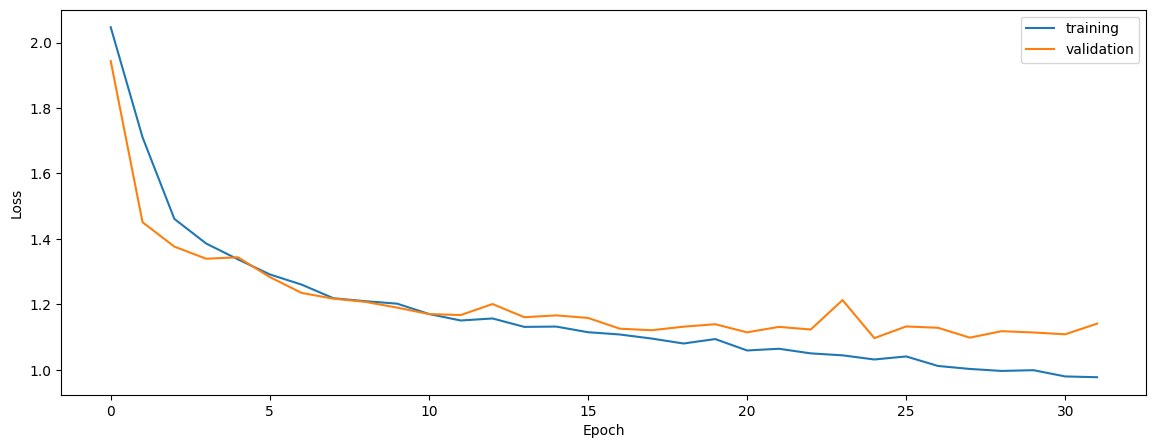

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6033552112883149


0.5707815757283393


0.553392366305974


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5733318123051182


0.5674349182444062


0.5226429911434929


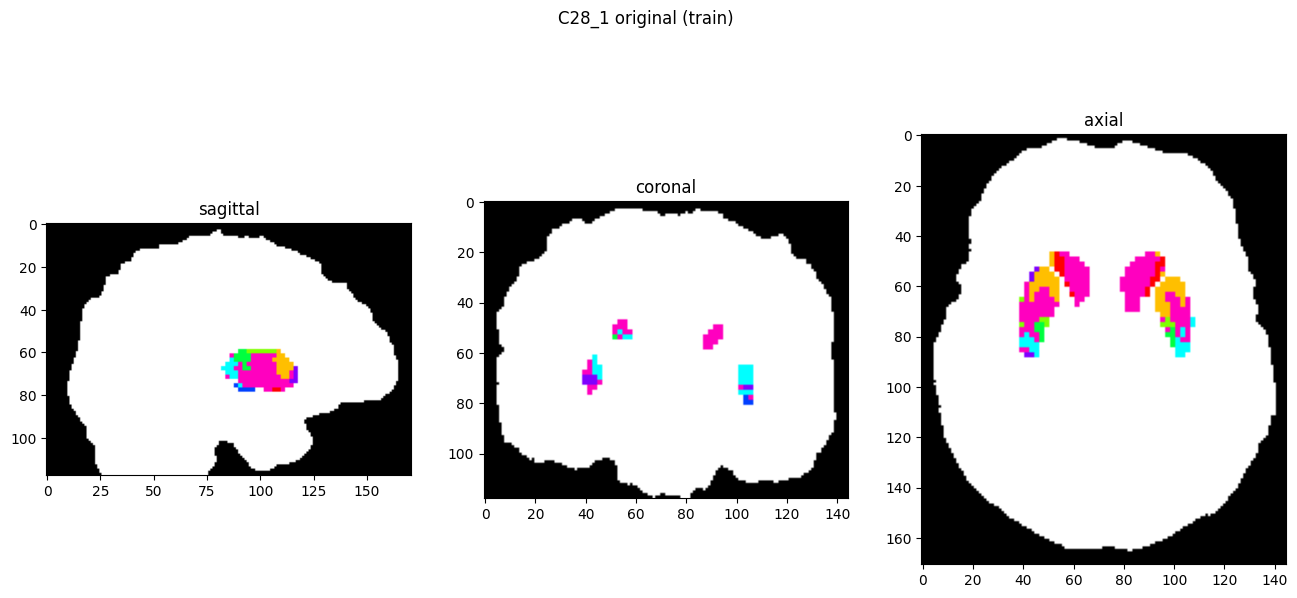

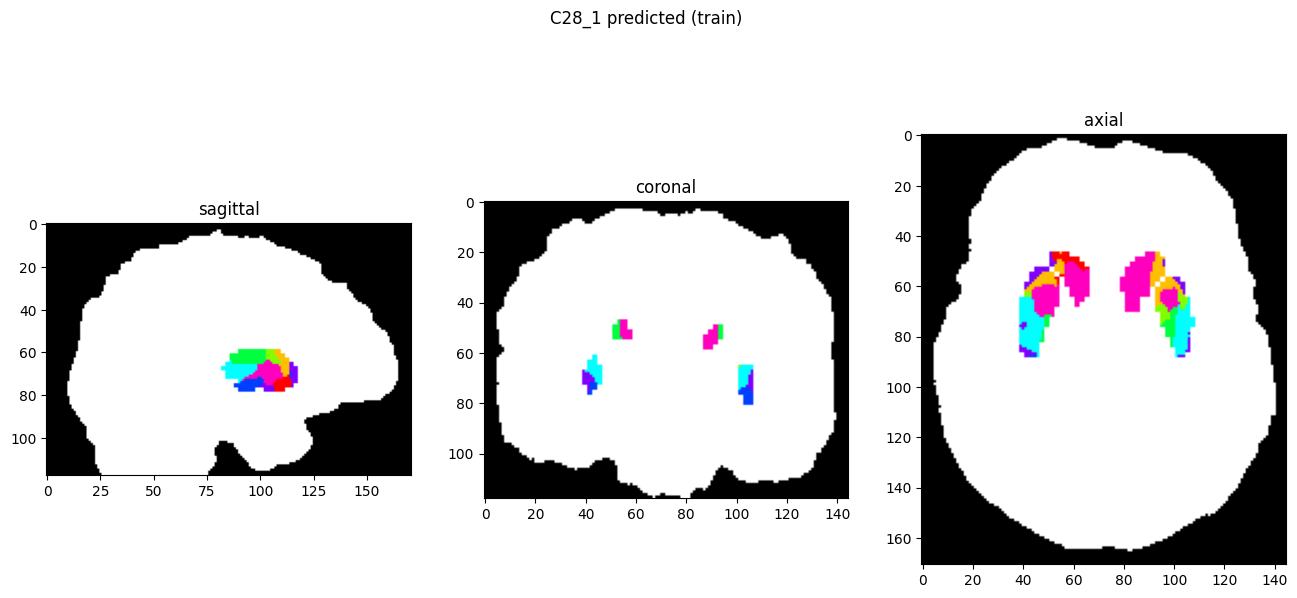

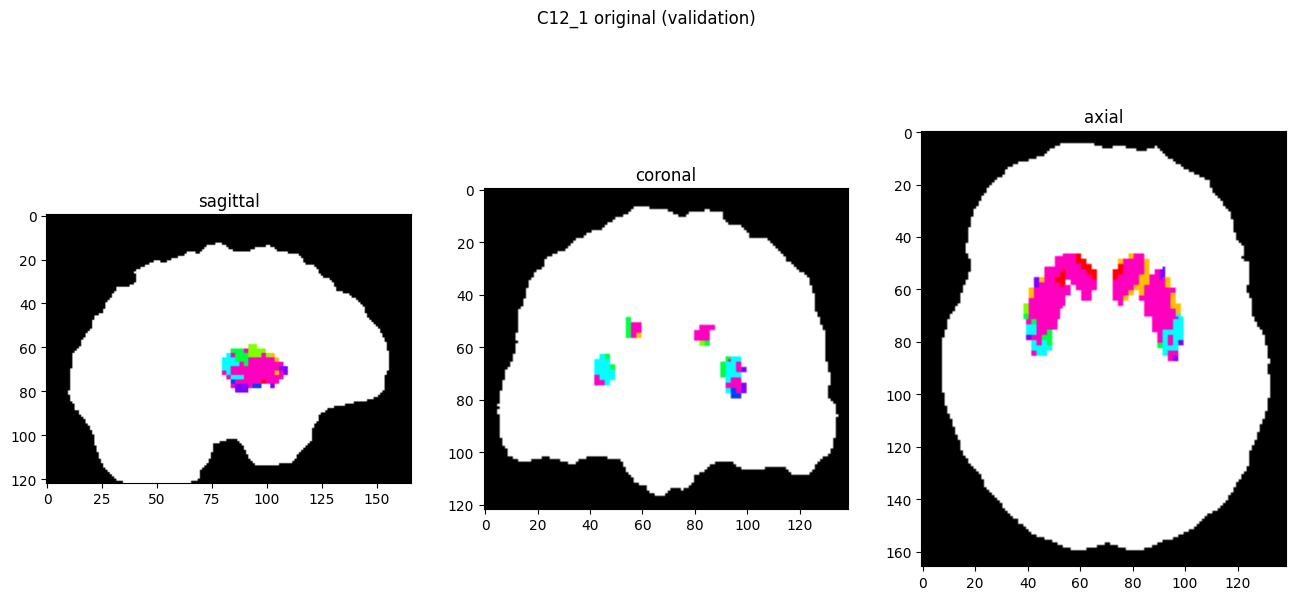

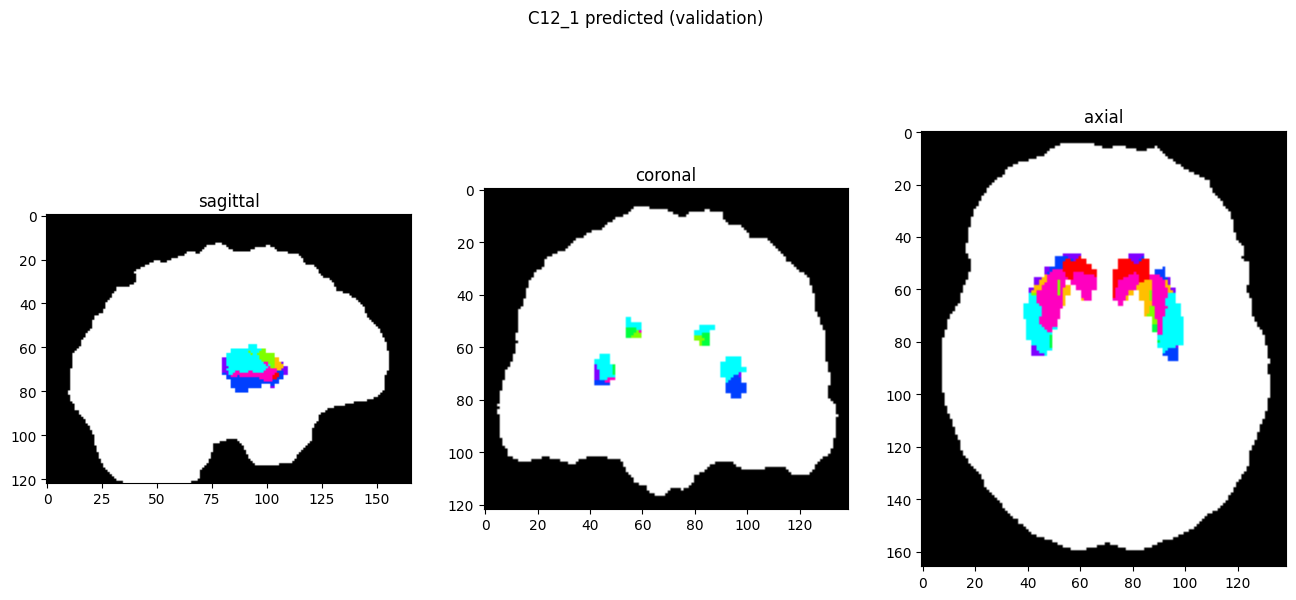

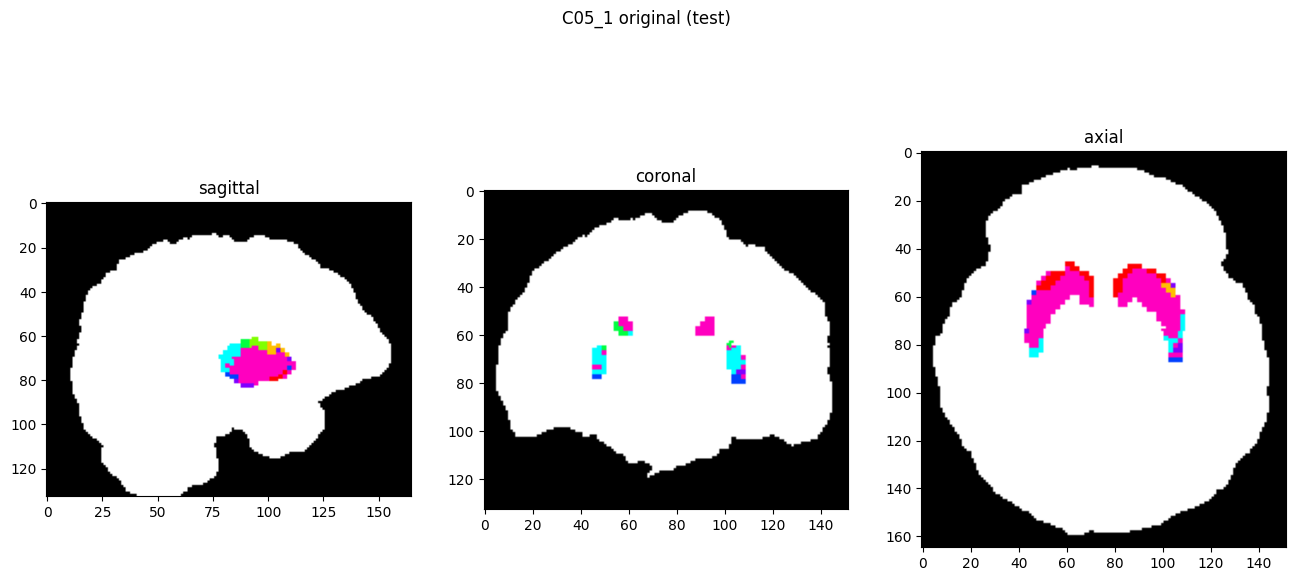

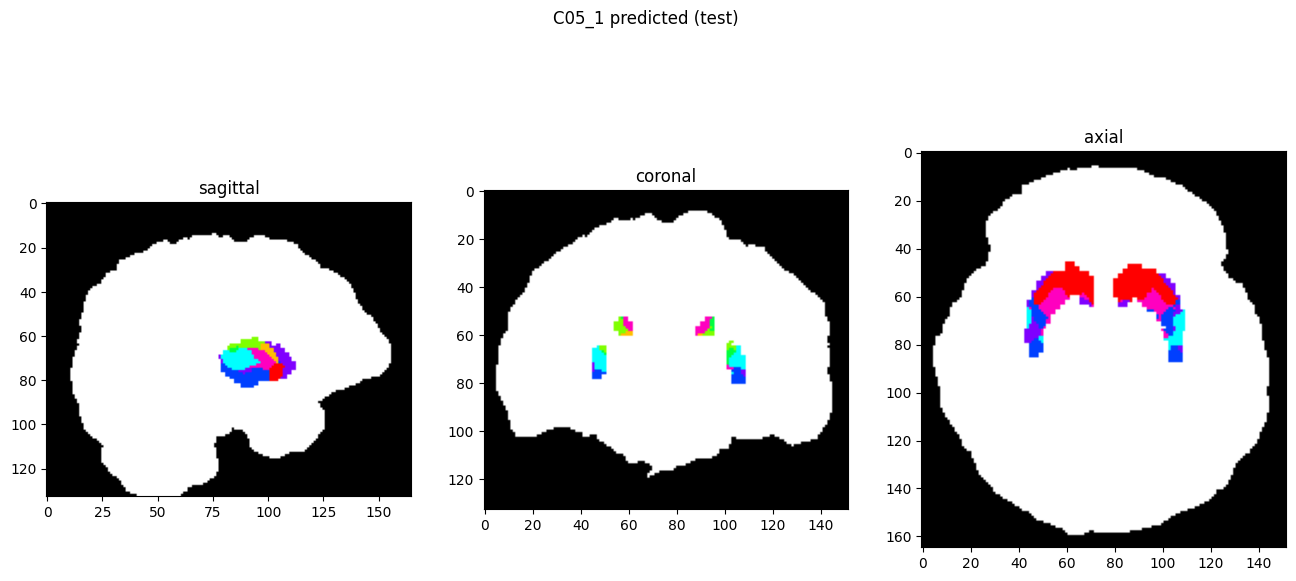

In [9]:
showResults(model, gen, threshold=0)